## Список функций
- apply_group_na
- fill_na_money

In [ ]:
def apply_group_na(column, df, id_column='PassengerId'):
  if 'HaveGroup' not in df.columns:
    df['HaveGroup'] = df[id_column].apply(lambda x: int(str(x).split('_')[0])).duplicated(False)
    df['PassengerGroup'] = df['PassengerId'].apply(lambda x: str(x).split('_')[0])

  groups_wo_column = df.loc[(df[column].isna()) & (df['HaveGroup'] == True)]['PassengerGroup']
  filled_na_column = df.loc[df['PassengerGroup'].isin(groups_wo_column)][['PassengerGroup', column]].sort_values(by=['PassengerGroup', column])[column].interpolate(method='pad')
  df.loc[df[column].isna(), column] = df.loc[df[column].isna()].index.map(filled_na_column)


In [ ]:
def ready_for_tree_traintest(delete_col, get_dummies_col, df, delete_na = True, target='Transported', train_test_flag=True):
  new_df = df.drop('Name', axis=1)
  new_df = new_df.dropna()

  for column in get_dummies_col:
    new_df = pd.concat([new_df, pd.get_dummies(new_df[column], prefix=column)], axis=1)

  new_y = new_df[target]

  delete_col.extend(get_dummies_col)
  delete_col.append(target)

  new_X = new_df.drop(delete_col, axis=1)

  if train_test_flag:
    X_new_train, X_new_valid, y_new_train, y_new_valid = train_test_split(new_X, new_y, test_size=0.3, random_state=17)
    return X_new_train, X_new_valid, y_new_train, y_new_valid
  else:
    return new_X, new_y

# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
from scipy.stats import norm, skew
from scipy import stats

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
import math
from sklearn.metrics import accuracy_score

import random
random.seed(42)

# Ипорт DF

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/Kaggle Competitions/Titanic_space/train.csv')

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train_df.shape

(8693, 14)

In [3]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
train_df.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [ ]:
train_df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle Competitions/Titanic_space/test.csv')

In [ ]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


- `PassengerId`- Уникальный идентификатор для каждого пассажира. Каждый идентификатор имеет форму gggg_pp, где gggg указывает группу, с которой путешествует пассажир, и pp его номер в группе. Люди в группе часто являются членами семьи, но не всегда.
- `HomePlanet`- Планета, с которой вылетел пассажир, обычно планета его постоянного проживания.
- `CryoSleep`- Указывает, решил ли пассажир быть помещен в анабиоз на время рейса. Пассажиры, находящиеся в криосне, прикованы к своим каютам.
- `Cabin`- Номер каюты, в которой находится пассажир. Принимает форму deck/num/side, где sideможет быть либо Pдля левого , либо Sдля правого борта .
- `Destination`- Планета, на которую высадится пассажир.
- `Age`- Возраст пассажира.
- `VIP`- Оплатил ли пассажир специальное VIP-обслуживание во время рейса.
- `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck-` Сумма, которую пассажир выставил счет за каждое из многочисленных роскошных удобств космического корабля «Титаник ».
- `Name`- Имя и фамилия пассажира.
- `Transported`- Был ли пассажир перенесен в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.

# Пробую точнее заполнить NA возраста

## Работа с concatenated_df

In [ ]:
concatenated_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [ ]:
concatenated_df['HaveGroup'] = concatenated_df['PassengerId'].apply(lambda x: int(str(x).split('_')[0])).duplicated(False)
concatenated_df['PassengerGroup'] = concatenated_df['PassengerId'].apply(lambda x: str(x).split('_')[0])

In [ ]:
concatenated_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HaveGroup,PassengerGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,False,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,True,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,True,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,False,0004


In [ ]:
#Get_group_peculiarities
group_apply = ['CryoSleep', 'Cabin', 'Destination']
for column in group_apply:
  apply_group_na(column=column, df=concatenated_df)

In [ ]:
concatenated_df['Side'] = concatenated_df['Cabin'].apply(lambda x: str(x)[-1])
concatenated_df['Deck'] = concatenated_df['Cabin'].apply(lambda x: str(x)[0])

In [ ]:
concatenated_df['Spending'] = concatenated_df[['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [ ]:
concatenated_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HaveGroup,PassengerGroup,Side,Deck
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,False,0001,P,B
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,False,0002,S,F
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,True,0003,S,A
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,True,0003,S,A
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,False,0004,S,F


## Доп исследования по возрасту

In [ ]:
age_less_18 = concatenated_df.loc[concatenated_df['Age']<18]

<Axes: xlabel='Deck', ylabel='count'>

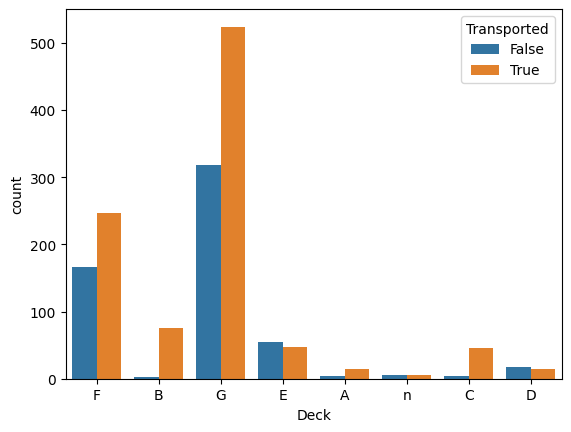

In [ ]:
sns.countplot(data=age_less_18, x='Deck', hue='Transported')

In [ ]:
children_wo_group = concatenated_df.loc[(concatenated_df['HaveGroup'] == False) & (concatenated_df['Age'] < 13)]

<Axes: xlabel='Deck', ylabel='count'>

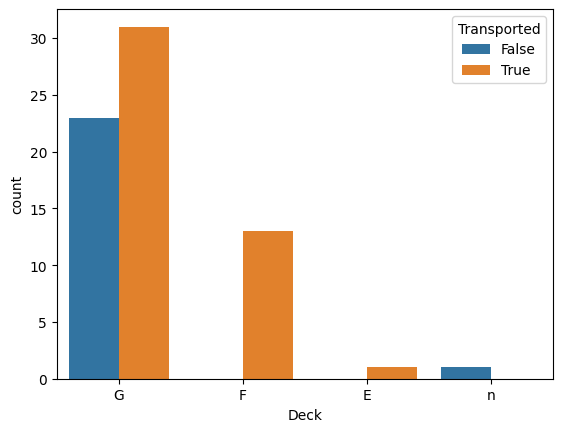

In [ ]:
sns.countplot(data=children_wo_group, x='Deck', hue='Transported')

In [ ]:
adults_wo_group = concatenated_df.loc[(concatenated_df['HaveGroup'] == False) & (concatenated_df['Age'] >= 18)]

In [ ]:
adults_wo_group.Deck.value_counts()

F    2475
G    1822
E     742
C     362
D     327
B     306
n     138
A     108
T       8
Name: Deck, dtype: int64

In [ ]:
adults_wo_group.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6902.000000,6748.000000,6745.000000,6745.000000,6745.000000,6758.000000
mean,30.790206,233.504594,368.940549,195.596442,265.504670,263.589524
std,12.558942,620.602987,1313.863375,547.095353,984.191779,1002.467816
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,122.000000,94.000000,81.000000,85.000000,62.000000
max,79.000000,11567.000000,26830.000000,10705.000000,22408.000000,22272.000000


In [ ]:
adults_wo_group.shape, children_wo_group.shape

((6902, 18), (101, 18))

In [ ]:
pd.pivot_table(children_wo_group, values='Age', index=['Deck'],
                       columns=['HomePlanet'], aggfunc = 'mean')

HomePlanet,Earth,Mars
Deck,,
E,6.000000,NaN
F,NaN,7.866667
G,6.924051,NaN
n,5.500000,NaN


<Axes: xlabel='Deck', ylabel='count'>

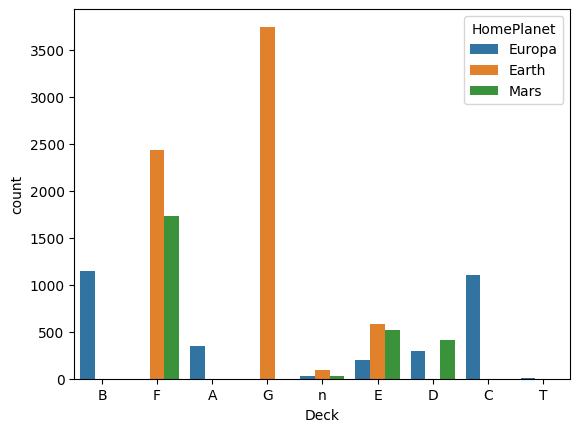

In [ ]:
sns.countplot(data=concatenated_df, x='Deck', hue='HomePlanet')

In [ ]:
children_in_sleep = concatenated_df.loc[(concatenated_df['Age'] < 13) & (concatenated_df['CryoSleep'] == True) & (concatenated_df['HaveGroup'] == False)]
children_in_sleep.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HaveGroup,PassengerGroup,Side,Deck,Spending
165,0190_01,Earth,True,G/32/S,55 Cancri e,11.0,False,0.0,0.0,0.0,0.0,0.0,NaN,False,False,0190,S,G,0.0
308,0341_01,Earth,True,G/57/P,PSO J318.5-22,5.0,False,0.0,0.0,0.0,0.0,0.0,Lorian Webstephrey,False,False,0341,P,G,0.0
412,0449_01,Earth,True,G/64/S,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,0.0,Nathy Moongton,True,False,0449,S,G,0.0
625,0650_01,Earth,True,G/95/S,PSO J318.5-22,3.0,False,0.0,0.0,0.0,0.0,0.0,Eulah Hammonton,True,False,0650,S,G,0.0
748,0787_01,Earth,True,G/114/P,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,0.0,NaN,Ritany Quinnerry,False,False,0787,P,G,0.0


In [ ]:
people_wo_age = concatenated_df.loc[concatenated_df['Age'].isna()]

In [ ]:
people_wo_age['Spending'] = people_wo_age['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck'].sum(axis=1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HaveGroup,PassengerGroup,Side,Deck
50,0052_01,Earth,False,G/6/S,TRAPPIST-1e,NaN,False,4.0,0.0,2.0,4683.0,0.0,Elaney Hubbarton,False,False,0052,S,G
64,0068_01,Mars,False,E/4/S,TRAPPIST-1e,NaN,False,793.0,0.0,2.0,253.0,0.0,Cinst Binie,False,False,0068,S,E
137,0149_01,Earth,True,G/27/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Billya Hubbarrison,True,False,0149,S,G
181,0202_02,Europa,False,A/2/P,55 Cancri e,NaN,False,0.0,2433.0,NaN,878.0,443.0,Vegas Embleng,True,True,0202,P,A
184,0206_01,Europa,False,C/9/S,55 Cancri e,NaN,False,2.0,1720.0,12.0,1125.0,122.0,Nuson Brugashed,True,False,0206,S,C


In [ ]:
concatenated_df.groupby('Deck').agg('mean')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HaveGroup,Spending
Deck,,,,,,,,
A,35.484330,119.316384,1430.838440,96.547009,737.360335,985.915254,0.692521,3331.817175
B,33.502199,103.007018,1253.541703,122.355124,797.278804,766.027145,0.724376,2984.519380
C,34.700364,177.213768,1736.619615,178.215919,937.570906,1063.996374,0.670232,3995.934938
D,33.446779,661.787413,665.786517,342.956704,430.480226,293.342697,0.529492,2340.761317
E,30.241194,313.043011,298.597243,235.166411,252.910276,271.637681,0.375844,1342.924981
F,28.364006,309.858373,150.555289,241.955720,167.276127,143.299616,0.353576,991.673154
G,23.934028,73.026724,82.918695,70.164696,83.779380,76.843767,0.413793,377.576803
T,35.545455,206.727273,2657.000000,67.400000,1956.636364,1034.636364,0.272727,5916.272727
n,30.354839,160.660377,414.748387,144.898734,317.283019,238.924528,0.000000,1257.262500


In [ ]:
concatenated_df.loc[(concatenated_df['Spending'] == 0) & (concatenated_df['CryoSleep'] == False) & concatenated_df['Age'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HaveGroup,PassengerGroup,Side,Deck,Spending
652,0684_01,Mars,False,F/145/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Sug Conie,True,True,0684,P,F,0.0
1915,2055_01,Earth,False,G/330/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Belly Woodwinez,False,True,2055,P,G,0.0
2151,2306_02,Europa,False,C/82/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Gomeron Colensid,True,True,2306,P,C,0.0
5167,5517_01,Mars,False,E/357/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Totax Brazo,False,False,5517,S,E,0.0
5620,5977_03,Europa,False,B/230/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Alhaula Inesely,True,True,5977,S,B,0.0
6775,7156_02,Mars,False,E/475/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Repart Ramad,True,True,7156,S,E,0.0
7419,7936_02,Earth,False,G/1284/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Carley Morelly,False,True,7936,P,G,0.0
9027,0720_02,Mars,False,E/52/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Krus Buko,NaN,True,0720,S,E,0.0
10581,4048_03,Mars,False,F/835/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Camonk Chkie,NaN,True,4048,P,F,0.0
10995,5024_02,Earth,False,G/822/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Hene Mallerez,NaN,True,5024,S,G,0.0


# Базовые закономерности

<Axes: xlabel='HomePlanet', ylabel='count'>

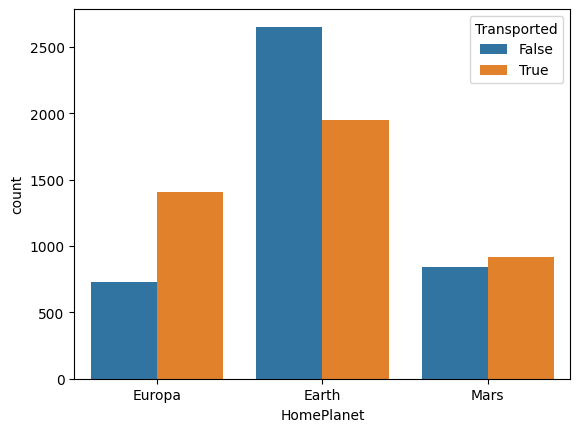

In [ ]:
sns.countplot(data=train_df, x='HomePlanet', hue='Transported')

<Axes: xlabel='CryoSleep', ylabel='count'>

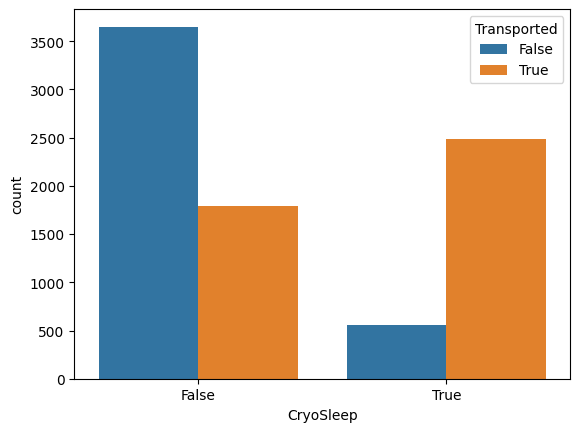

In [ ]:
sns.countplot(data=train_df, x='CryoSleep', hue='Transported')

<Axes: xlabel='CryoSleep', ylabel='count'>

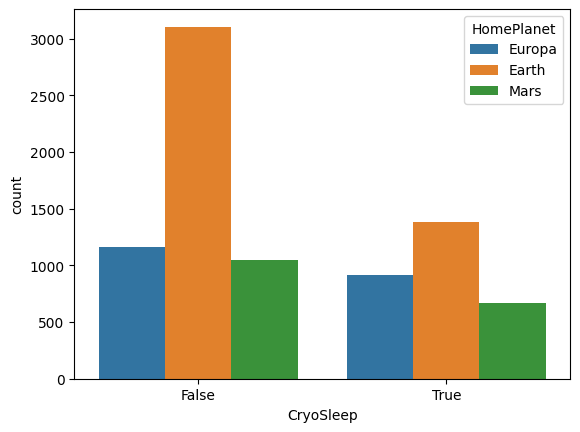

In [ ]:
sns.countplot(data=train_df, x='CryoSleep', hue='HomePlanet')

## Доп ячейка "один в комнате"

In [ ]:
train_df_one = train_df.copy()

In [ ]:
train_df_two = train_df.copy()

In [ ]:
train_df_one['OneInRoom'] = train_df_one['Cabin'].duplicated(keep=False)

In [ ]:
X_train_one, X_valid_one, y_train_one, y_valid_one = do_job(train_df_one, train_test=True)

In [ ]:
tree_one = DecisionTreeClassifier(max_depth=9, min_samples_leaf=10, random_state=17)

In [ ]:
tree_two = DecisionTreeClassifier(max_depth=9, min_samples_leaf=10, random_state=17)

In [ ]:
tree_one.fit(X_train_one, y_train_one)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=10, random_state=17)

In [ ]:
X_train_two, X_valid_two, y_train_two, y_valid_two = do_job(train_df_two, train_test=True)

In [ ]:
tree_two.fit(X_train_two, y_train_two)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=10, random_state=17)

In [ ]:
print(f"Дерево с колоной один в комнате {tree_one.score(X_valid_one, y_valid_one)}")
print(f"Без колонки {tree_two.score(X_valid_two, y_valid_two)}")

Дерево с колоной один в комнате 0.7879601226993865
Без колонки 0.7848926380368099


## действительно ли внутри группы всегда один результат перемещения

In [ ]:
train_df_two['HaveGroup'] = train_df_two['PassengerId'].apply(lambda x: int(str(x).split('_')[0])).duplicated(False)
train_df_two['PassengerGroup'] = train_df_two['PassengerId'].apply(lambda x: str(x).split('_')[0])

In [ ]:
train_df_two.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HaveGroup,PassengerGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,False,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,True,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,True,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,False,0004


In [ ]:
train_df_groups = train_df_two.loc[train_df_two['HaveGroup'] == True]

In [ ]:
train_df_groups_not_alone = train_df_groups.copy()

In [ ]:
train_df_groups_not_alone['NotAlone'] = train_df_groups_not_alone['Cabin'].duplicated(keep=False)

In [ ]:
train_df_groups_not_alone.loc[(train_df_groups_not_alone['NotAlone'] == True) &( train_df_groups_not_alone['Age'] < 2)].Transported.value_counts()

True     170
False     45
Name: Transported, dtype: int64

# *Baseline 1.*

In [ ]:
X_out_na.shape, y_out_na.shape

((6606, 13), (6606,))

In [ ]:
X_out_na.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [ ]:
X_out_na['Destination'].value_counts()

TRAPPIST-1e      4576
55 Cancri e      1407
PSO J318.5-22     623
Name: Destination, dtype: int64

In [ ]:
X_out_na['Side'] = X_out_na['Cabin'].apply(lambda x: str(x)[-1])

In [ ]:
X_out_na = pd.concat(
    [
        X_out_na,
        pd.get_dummies(X_out_na["HomePlanet"], prefix="HomePlanet"),
        pd.get_dummies(X_out_na["Destination"], prefix="Destination"),
    ],
    axis=1,
)

In [ ]:
X_out_na.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,P,0,1,0,0,0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,S,1,0,0,0,0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,S,0,1,0,0,0,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,S,0,1,0,0,0,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,S,1,0,0,0,0,1


In [ ]:
X_out_na = pd.concat(
    [
        X_out_na,
        pd.get_dummies(X_out_na["Side"], prefix="Side"),
    ],
    axis=1,
)

In [ ]:
X_out_na.drop(labels=['PassengerId', 'Cabin', 'HomePlanet', 'Cabin', 'Destination', 'Name'], axis=1, inplace=True)

In [ ]:
X_out_na.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Side_P,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,P,0,1,0,0,0,1,1,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,S,1,0,0,0,0,1,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,S,0,1,0,0,0,1,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,S,0,1,0,0,0,1,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,S,1,0,0,0,0,1,0,1


In [ ]:
X_out_na.drop(labels=['Side'], axis=1, inplace=True)

In [ ]:
X_train_outna, X_valid_outna, y_train_outna, y_valid_outna = train_test_split(X_out_na, y_out_na, test_size=0.3, random_state=17)

In [ ]:
first_tree = DecisionTreeClassifier(random_state=17)

In [ ]:
np.mean(cross_val_score(first_tree, X_train_outna, y_train_outna, cv=5))

0.7374526734526735

## Подстроим параметры

In [ ]:
tree_params = {"max_depth": list(range(10, 15)), "min_samples_leaf": list(range(10, 20))}

In [ ]:
first_tree_gscv = GridSearchCV(first_tree, tree_params, cv=5, n_jobs=-1)

In [ ]:
first_tree_gscv.fit(X_train_outna, y_train_outna)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14],
                         'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 19]})

In [ ]:
first_tree_gscv.best_estimator_

DecisionTreeClassifier(max_depth=11, min_samples_leaf=10, random_state=17)

In [ ]:
first_tree_gscv

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14],
                         'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 19]})

In [ ]:
np.mean(cross_val_score(first_tree_gscv.best_estimator_, X_train_outna, y_train_outna, cv=5))

0.785028431028431

In [ ]:
X_train_outna['ServiecesAll'] = X_train_outna[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [ ]:
X_train_outna[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1).head()

2836    808.0
5824      0.0
3734      0.0
1382      0.0
1441      0.0
dtype: float64

In [ ]:
X_train_outna.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Side_P,Side_S,ServiecesAll
2836,False,35.0,False,741.0,0.0,31.0,0.0,36.0,0,0,1,0,0,1,0,1,808.0
5824,True,42.0,False,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,0.0
3734,True,46.0,False,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,1,0,0.0
1382,True,44.0,False,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,1,0,0.0
1441,True,35.0,False,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,1,0.0


In [ ]:
first_tree_gscv.fit(X_train_outna, y_train_outna)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14],
                         'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 19]})

In [ ]:
np.mean(cross_val_score(first_tree_gscv.best_estimator_, X_train_outna, y_train_outna, cv=5))

0.7794072774072773

In [ ]:
X_train_outna_outspare = X_train_outna.drop(['Side_S', 'ServiecesAll'], axis=1)

In [ ]:
first_tree_gscv.fit(X_train_outna_outspare, y_train_outna)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14],
                         'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 19]})

In [ ]:
np.mean(cross_val_score(first_tree_gscv.best_estimator_, X_train_outna_outspare, y_train_outna, cv=5))

0.7175582075582077

In [ ]:
y_no_na = df_out_na['Transported']
X_no_na = df_out_na.drop(labels=['Transported'], axis=1)

In [ ]:
X_no_na['Side'] = X_no_na['Cabin'].apply(lambda x: str(x)[-1])

In [ ]:
X_no_na['Deck'] = X_no_na['Cabin'].apply(lambda x: str(x)[0])

In [ ]:
X_no_na['Cabin'].apply(lambda x: str(x)[0]).value_counts()

F    2152
G    1973
E     683
B     628
C     587
D     374
A     207
T       2
Name: Cabin, dtype: int64

In [ ]:
X_no_na.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Side,Deck
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,P,B
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,S,F
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,S,A
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,S,A
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,S,F


In [ ]:
X_no_na['Cabin'].apply(lambda x: x.split('/')).value_counts()

[G, 1476, S]    7
[E, 13, S]      7
[C, 137, S]     7
[G, 734, S]     7
[B, 11, S]      7
               ..
[E, 233, S]     1
[E, 209, P]     1
[G, 548, S]     1
[D, 108, P]     1
[B, 153, P]     1
Name: Cabin, Length: 5305, dtype: int64

In [ ]:
X_no_na_wtht_extra = X_no_na.drop(['Name', 'PassengerId', 'Cabin'], axis=1)

In [ ]:
X_no_na_wtht_extra = pd.concat(
    [
        X_no_na_wtht_extra,
        pd.get_dummies(X_no_na_wtht_extra["Side"], prefix="Side"),
        pd.get_dummies(X_no_na_wtht_extra["HomePlanet"], prefix="HomePlanet"),
        pd.get_dummies(X_no_na_wtht_extra["Destination"], prefix="Destination"),
        pd.get_dummies(X_no_na_wtht_extra["Deck"], prefix="Deck"),
    ],
    axis=1,
)

In [ ]:
X_no_na_wtht_extra.drop(['Destination', 'HomePlanet', "Side", "Deck"], axis=1, inplace=True)
X_no_na_wtht_extra.head()


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Side_P,Side_S,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,1,0,...,0,1,0,1,0,0,0,0,0,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,1,...,0,1,1,0,0,0,0,0,0,0
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,1,...,0,1,1,0,0,0,0,0,0,0
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
no_na_tree_gscv = GridSearchCV(first_tree, tree_params, cv=5, n_jobs=-1)

In [ ]:
no_na_tree_gscv.fit(X_no_na_wtht_extra, y_no_na)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14],
                         'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 19]})

In [ ]:
no_na_tree_gscv.best_estimator_

DecisionTreeClassifier(max_depth=13, min_samples_leaf=19, random_state=17)

In [ ]:
np.mean(cross_val_score(no_na_tree_gscv.best_estimator_, X_train_outna, y_train_outna, cv=5))

0.7746458406458407

# **Работаем с NA**

In [ ]:
train_df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [ ]:
train_df.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [ ]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [ ]:
missing_data = X.isnull()

In [ ]:
missing_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
for column in missing_data.columns.values:
  print(column)
  print(missing_data[column].value_counts())
  print(" ")

PassengerId
False    8693
Name: PassengerId, dtype: int64
 
HomePlanet
False    8492
True      201
Name: HomePlanet, dtype: int64
 
CryoSleep
False    8476
True      217
Name: CryoSleep, dtype: int64
 
Cabin
False    8494
True      199
Name: Cabin, dtype: int64
 
Destination
False    8511
True      182
Name: Destination, dtype: int64
 
Age
False    8514
True      179
Name: Age, dtype: int64
 
VIP
False    8490
True      203
Name: VIP, dtype: int64
 
RoomService
False    8512
True      181
Name: RoomService, dtype: int64
 
FoodCourt
False    8510
True      183
Name: FoodCourt, dtype: int64
 
ShoppingMall
False    8485
True      208
Name: ShoppingMall, dtype: int64
 
Spa
False    8510
True      183
Name: Spa, dtype: int64
 
VRDeck
False    8505
True      188
Name: VRDeck, dtype: int64
 
Name
False    8493
True      200
Name: Name, dtype: int64
 


In [ ]:
X.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64

In [ ]:
train_df.groupby(X['HomePlanet'].isnull()).mean()

<ipython-input-21-0c76d82cb94d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df.groupby(X['HomePlanet'].isnull()).mean()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
HomePlanet,,,,,,,
False,28.828743,225.201034,462.756828,174.477626,313.029596,305.334979,0.503415
True,28.793970,202.789744,262.638191,141.742268,231.762626,284.915000,0.512438


In [ ]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [ ]:
X['Deck'] = X['Cabin'].apply(lambda x: str(x)[0])
X['Side'] = X['Cabin'].apply(lambda x: str(x)[-1])

In [ ]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,S


In [ ]:
df = train_df

## Начало обработки NA

In [ ]:
train_df['Deck'] = train_df['Cabin'].apply(lambda x: str(x)[0])
train_df['Side'] = train_df['Cabin'].apply(lambda x: str(x)[-1])

In [ ]:
train_df['PassengerGroup'] = train_df['PassengerId'].apply(lambda x: str(x).split('_')[0])

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,0004


In [ ]:
train_df['HaveGroup'] = train_df['PassengerId'].apply(lambda x: int(str(x).split('_')[0])).duplicated(False)

In [ ]:
groups_wo_cabin = train_df.loc[(train_df['Cabin'].isna()) & (train_df['HaveGroup'] == True)]['PassengerGroup']


In [ ]:
filled_na_cabin = train_df.loc[train_df['PassengerGroup'].isin(groups_wo_cabin)][['PassengerGroup', 'Cabin']].sort_values(by=['PassengerGroup', 'Cabin'])['Cabin'].interpolate(method='pad')
#sort_values(by='PassengerGroup') не нужен, тк. DataFrame.groupby(sort=True)

In [ ]:
filled_na_cabin.sort_index().head()

103     B/5/P
104     B/5/P
105     B/5/P
106     B/5/P
227    F/47/S
Name: Cabin, dtype: object

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0001,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,0002,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,0003,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,0003,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,0004,False


In [ ]:
train_df.loc[train_df['Cabin'].isna(), 'Cabin'] = train_df.loc[train_df['Cabin'].isna()].index.map(filled_na_cabin)

In [ ]:
train_df.groupby(train_df['Destination'].isnull()).mean()

<ipython-input-32-adb35ed6895e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df.groupby(train_df['Destination'].isnull()).mean()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup
Destination,,,,,,,,
False,28.800120,225.071883,460.516199,174.240491,309.959429,306.670270,0.503584,0.447538
True,30.122905,206.798883,342.585227,149.728814,366.027933,220.888889,0.505495,0.434066


In [ ]:
train_df.groupby(train_df['CryoSleep'].isnull()).mean()

<ipython-input-33-f1af59a11f98>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df.groupby(train_df['CryoSleep'].isnull()).mean()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup
CryoSleep,,,,,,,,
False,28.851530,224.850187,458.003857,174.429555,311.994577,305.100663,0.504011,0.445729
True,27.921296,218.413953,460.920561,145.995215,277.641509,295.142857,0.488479,0.506912


In [ ]:
train_df['CabinNum'] = train_df['Cabin'].apply(lambda x: str(x).split('_'))

In [ ]:
train_df.loc[train_df['Cabin'].notna(), 'Cabin'].apply(lambda x: str(x).split('/')[1])

0          0
1          0
2          0
3          0
4          1
        ... 
8688      98
8689    1499
8690    1500
8691     608
8692     608
Name: Cabin, Length: 8594, dtype: object

In [ ]:
train_df.iloc[13:20]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum
13,0010_01,Earth,False,G/1/S,TRAPPIST-1e,48.0,False,719.0,1.0,65.0,0.0,24.0,Reney Baketton,False,G,S,0010,False,[G/1/S]
14,0011_01,Earth,False,F/2/P,TRAPPIST-1e,28.0,False,8.0,974.0,12.0,2.0,7.0,Elle Bertsontry,True,F,P,0011,False,[F/2/P]
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False,n,n,0012,False,[nan]
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False,F,P,0014,False,[F/3/P]
17,0015_01,Earth,False,F/4/P,55 Cancri e,24.0,False,0.0,1.0,0.0,0.0,637.0,Carry Hughriend,False,F,P,0015,False,[F/4/P]
18,0016_01,Mars,True,F/5/P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,Alus Upead,True,F,P,0016,False,[F/5/P]
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Lyde Brighttt,True,G,P,0017,True,[G/0/P]


In [ ]:
groups_wo_HomePlanet = train_df.loc[(train_df['HomePlanet'].isna()) & (train_df['HaveGroup'] == True)]['PassengerGroup']

In [ ]:
filled_na_HomePlanet = train_df.loc[train_df['PassengerGroup'].isin(groups_wo_HomePlanet)][['PassengerGroup', 'HomePlanet']].sort_values(by=['PassengerGroup', 'HomePlanet'])['HomePlanet'].interpolate(method='pad')

In [ ]:
train_df.loc[train_df['HomePlanet'].isna(), 'HomePlanet'] = train_df.loc[train_df['HomePlanet'].isna()].index.map(filled_na_HomePlanet)

In [ ]:
train_df.loc[train_df['Age'] < 10].isnull().sum()

PassengerId        0
HomePlanet         3
CryoSleep         20
Cabin              1
Destination        8
Age                0
VIP               21
RoomService       17
FoodCourt         10
ShoppingMall      18
Spa               13
VRDeck            19
Name              22
Transported        0
Deck               0
Side               0
PassengerGroup     0
HaveGroup          0
CabinNum           0
dtype: int64

In [ ]:
train_df.loc[(train_df['Age'] < 10) & (train_df['HomePlanet'].isna())]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum
4817,5137_01,NaN,False,G/839/S,TRAPPIST-1e,9.0,False,0.0,0.0,0.0,0.0,0.0,Milyn Llobsoney,True,G,S,5137,False,[G/839/S]
5988,6339_01,NaN,False,G/1022/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Stanya Schmondez,False,G,P,6339,False,[G/1022/P]
8319,8883_01,NaN,False,G/1438/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,Rence Monroellynn,False,G,P,8883,False,[G/1438/P]


In [ ]:
train_df[['HomePlanet', 'Destination']].value_counts()

HomePlanet  Destination  
Earth       TRAPPIST-1e      3125
Mars        TRAPPIST-1e      1503
Europa      TRAPPIST-1e      1209
            55 Cancri e       896
Earth       PSO J318.5-22     716
            55 Cancri e       693
Mars        55 Cancri e       194
            PSO J318.5-22      50
Europa      PSO J318.5-22      19
dtype: int64

In [ ]:
#id - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
#Функция создаёт две дополнительные колонки 'HaveGroup' и 'PassengerGroup'
#Возвращает дф с заполненными интерполяцией NA значениями ВНУТРИ ГРУППЫ

def apply_group_na(column, df, id_column='PassengerId'):
  df['HaveGroup'] = df[id_column].apply(lambda x: int(str(x).split('_')[0])).duplicated(False)
  df['PassengerGroup'] = train_df['PassengerId'].apply(lambda x: str(x).split('_')[0])
  groups_wo_column = df.loc[(df[column].isna()) & (df['HaveGroup'] == True)]['PassengerGroup']
  filled_na_column = train_df.loc[train_df['PassengerGroup'].isin(groups_wo_column)][['PassengerGroup', column]].sort_values(by=['PassengerGroup', column])[column].interpolate(method='pad')
  train_df.loc[train_df[column].isna(), column] = train_df.loc[train_df[column].isna()].index.map(filled_na_column)



In [ ]:
apply_group_na(column='Destination', df=train_df)

In [ ]:
train_df.isnull().sum()

PassengerId         0
HomePlanet        109
CryoSleep         217
Cabin              99
Destination       103
Age               179
VIP               203
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
Deck                0
Side                0
PassengerGroup      0
HaveGroup           0
CabinNum            0
dtype: int64

In [ ]:
train_df['Youth'] = train_df['Age'].apply(lambda x: 'baby' if x<3 else ('Old' if x>50 else 'Norm'))

<Axes: xlabel='Youth', ylabel='count'>

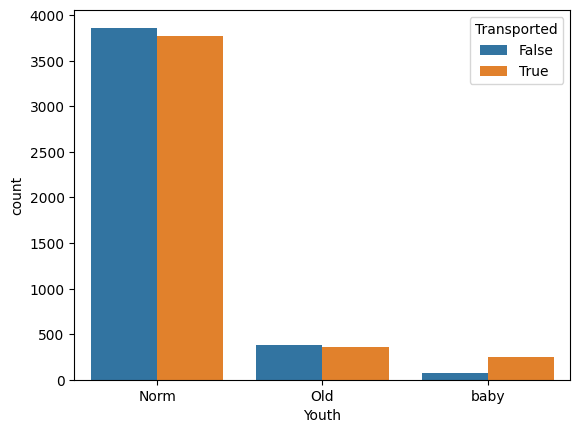

In [ ]:
sns.countplot(data=train_df, x='Youth', hue='Transported')

In [ ]:
train_df.loc[train_df['Age']<2]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Lyde Brighttt,True,G,P,0017,True,[G/0/P],baby
21,0020_01,Earth,True,E/0/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,Almary Brantuarez,False,E,S,0020,True,[E/0/S],baby
25,0020_05,Earth,True,E/0/S,PSO J318.5-22,1.0,False,NaN,0.0,0.0,0.0,0.0,Mael Brantuarez,False,E,S,0020,True,[E/0/S],baby
61,0067_01,Earth,True,G/10/S,PSO J318.5-22,0.0,False,0.0,0.0,0.0,0.0,0.0,Ninaha Leeves,True,G,S,0067,True,[G/10/S],baby
86,0092_02,Earth,True,G/9/P,TRAPPIST-1e,0.0,False,0.0,0.0,NaN,0.0,0.0,Stald Hewson,True,G,P,0092,True,[G/9/P],baby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8584,9163_01,Earth,True,G/1477/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Idace Edwartizman,True,G,S,9163,False,[G/1477/S],baby
8649,9227_03,Earth,True,G/1498/P,PSO J318.5-22,1.0,False,0.0,0.0,0.0,0.0,0.0,Paulas Hinglendez,True,G,P,9227,True,[G/1498/P],baby
8650,9227_04,Earth,True,G/1498/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Robyny Hinglendez,True,G,P,9227,True,[G/1498/P],baby
8654,9231_02,Mars,False,F/1888/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Walls Paie,True,F,P,9231,True,[F/1888/P],baby


In [ ]:
cabin_num_wo_na = train_df.loc[train_df['Cabin'].notna()]['Cabin'].apply(lambda x: x.split('/')[1])

In [ ]:
train_df.loc[train_df['CabinNum'].notna(), 'CabinNum'] = train_df.loc[train_df['CabinNum'].notna()].index.map(cabin_num_wo_na)

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0001,False,0,Norm
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,0002,False,0,Norm
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,0003,True,0,Old
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,0003,True,0,Norm
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,0004,False,1,Norm


In [ ]:
train_df.loc[(train_df['CabinNum'] == '82'), 'Transported'].value_counts()

True     17
False    11
Name: Transported, dtype: int64

In [ ]:
 train_df.loc[train_df['Age'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth
50,0052_01,Earth,False,G/6/S,TRAPPIST-1e,NaN,False,4.0,0.0,2.0,4683.0,0.0,Elaney Hubbarton,False,G,S,0052,False,6,Norm
64,0068_01,Mars,False,E/4/S,TRAPPIST-1e,NaN,False,793.0,0.0,2.0,253.0,0.0,Cinst Binie,False,E,S,0068,False,4,Norm
137,0149_01,Earth,True,G/27/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Billya Hubbarrison,True,G,S,0149,False,27,Norm
181,0202_02,Europa,False,A/2/P,55 Cancri e,NaN,False,0.0,2433.0,NaN,878.0,443.0,Vegas Embleng,True,A,P,0202,True,2,Norm
184,0206_01,Europa,False,C/9/S,55 Cancri e,NaN,False,2.0,1720.0,12.0,1125.0,122.0,Nuson Brugashed,True,C,S,0206,False,9,Norm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8274,8835_01,Earth,True,G/1425/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Shalle Bartines,False,G,S,8835,False,1425,Norm
8301,8862_03,Europa,True,C/329/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Alchib Myling,True,C,S,8862,True,329,Norm
8374,8956_04,Earth,False,G/1453/P,TRAPPIST-1e,NaN,False,194.0,1.0,10.0,629.0,0.0,Krisa Bonnondry,False,G,P,8956,True,1453,Norm
8407,8988_01,Earth,True,G/1448/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Maen Fowlesterez,True,G,S,8988,True,1448,Norm


In [ ]:
train_df.loc[train_df['Age'].isna()]['Transported'].value_counts()

True     90
False    89
Name: Transported, dtype: int64

In [ ]:
train_df['Age'].fillna(train_df["Age"].median(), inplace=True)

In [ ]:
train_df.isnull().sum()

PassengerId         0
HomePlanet        109
CryoSleep         217
Cabin              99
Destination       103
Age                 0
VIP               203
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
Deck                0
Side                0
PassengerGroup      0
HaveGroup           0
CabinNum           99
Youth               0
dtype: int64

In [ ]:
train_df.loc[train_df['VIP'].isna()]['Transported'].value_counts()

True     104
False     99
Name: Transported, dtype: int64

In [ ]:
train_df.loc[train_df["Age"] < 13].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,806.000000,786.0,794.0,786.0,792.0,782.0
mean,4.516129,0.0,0.0,0.0,0.0,0.0
std,3.923063,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0
25%,1.000000,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0
75%,8.000000,0.0,0.0,0.0,0.0,0.0
max,12.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df.loc[train_df["Age"] < 13, 'FoodCourt'].isna().value_counts()

False    794
True      12
Name: FoodCourt, dtype: int64

In [ ]:
train_df.isnull().sum()

PassengerId         0
HomePlanet        109
CryoSleep         217
Cabin              99
Destination       103
Age                 0
VIP               203
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              200
Transported         0
Deck                0
Side                0
PassengerGroup      0
HaveGroup           0
CabinNum           99
Youth               0
dtype: int64

In [ ]:
train_df.loc[train_df['CryoSleep'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth
92,0099_02,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Thewis Connelson,True,G,P,0099,True,12,baby
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,Carry Cleachrand,False,F,P,0105,False,21,Norm
104,0110_02,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.0,Aldeba Bootious,False,B,P,0110,True,5,Norm
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,Rohs Pead,True,F,P,0115,False,24,Norm
152,0173_01,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.0,Hilip Grifford,True,E,S,0173,False,11,Old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8620,9197_01,Europa,NaN,C/308/P,55 Cancri e,44.0,False,0.0,0.0,0.0,0.0,0.0,Bellus Platch,True,C,P,9197,True,308,Norm
8651,9227_05,Earth,NaN,G/1498/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,Hard Hinglendez,False,G,P,9227,True,1498,Norm
8664,9246_01,Earth,NaN,G/1490/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,G,S,9246,False,1490,Norm
8675,9259_01,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,11.0,NaN,Annah Gilleyons,True,F,P,9259,False,1893,Norm


In [ ]:
train_df.iloc[90:95]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth
90,0098_02,Earth,False,G/11/P,TRAPPIST-1e,26.0,False,0.0,2811.0,957.0,0.0,87.0,Leence Carezquez,True,G,P,0098,True,11,Norm
91,0099_01,Earth,False,F/19/P,PSO J318.5-22,23.0,False,311.0,427.0,526.0,37.0,0.0,Aliey Leetersoney,False,F,P,0099,True,19,Norm
92,0099_02,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Thewis Connelson,True,G,P,0099,True,12,baby
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Book Trad,True,n,n,0101,False,NaN,Norm
94,0102_01,Earth,False,F/23/S,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,830.0,91.0,Ritany Holson,False,F,S,0102,False,23,Norm


In [ ]:
train_df['Spending'] = train_df[['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,B,P,0001,False,0,Norm,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,F,S,0002,False,0,Norm,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,A,S,0003,True,0,Old,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,A,S,0003,True,0,Norm,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,F,S,0004,False,1,Norm,1091.0


In [ ]:
train_df.loc[train_df['VIP'] == True, 'Spending'].describe()

count      199.000000
mean      4425.477387
std       5121.300417
min          0.000000
25%       1281.000000
50%       2767.000000
75%       6120.500000
max      31076.000000
Name: Spending, dtype: float64

In [ ]:
train_df.loc[train_df['VIP'] == False, 'Spending'].describe()

count     8291.000000
mean      1371.504644
std       2683.701966
min          0.000000
25%          0.000000
50%        705.000000
75%       1369.000000
max      35987.000000
Name: Spending, dtype: float64

In [ ]:
train_df[['VIP', 'HomePlanet', 'Destination']].value_counts()

VIP    HomePlanet  Destination  
False  Earth       TRAPPIST-1e      3077
       Mars        TRAPPIST-1e      1435
       Europa      TRAPPIST-1e      1143
                   55 Cancri e       820
       Earth       PSO J318.5-22     703
                   55 Cancri e       672
       Mars        55 Cancri e       192
True   Europa      55 Cancri e        64
                   TRAPPIST-1e        57
       Mars        TRAPPIST-1e        56
False  Mars        PSO J318.5-22      40
True   Europa      PSO J318.5-22      10
False  Europa      PSO J318.5-22       9
True   Mars        PSO J318.5-22       8
dtype: int64

In [ ]:
train_df.loc[(train_df['HomePlanet'] == 'Earth') & train_df['VIP'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
38,0036_01,Earth,False,F/8/S,55 Cancri e,15.0,NaN,0.0,492.0,48.0,...,401.0,Marina Leodger,False,F,S,0036,False,8,Norm,961.0
102,0108_03,Earth,False,G/19/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,0.0,...,0.0,Oline Handertiz,True,G,S,0108,True,19,baby,0.0
646,0679_01,Earth,False,G/104/S,TRAPPIST-1e,20.0,NaN,NaN,215.0,0.0,...,0.0,Vana Nichoan,False,G,S,0679,False,104,Norm,756.0
649,0680_03,Earth,True,G/105/P,TRAPPIST-1e,5.0,NaN,0.0,0.0,0.0,...,0.0,Joandy Camerrison,False,G,P,0680,True,105,Norm,0.0
780,0819_01,Earth,True,G/121/S,PSO J318.5-22,23.0,NaN,0.0,0.0,0.0,...,0.0,Patsya Gainney,True,G,S,0819,False,121,Norm,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8314,8874_01,Earth,True,G/1436/P,TRAPPIST-1e,24.0,NaN,0.0,0.0,0.0,...,0.0,Cline Popelacruz,False,G,P,8874,False,1436,Norm,0.0
8428,9003_01,Earth,False,F/1744/S,TRAPPIST-1e,23.0,NaN,2.0,167.0,0.0,...,555.0,Rence Llobsoney,True,F,S,9003,False,1744,Norm,724.0
8494,9074_01,Earth,True,G/1460/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,NaN,...,0.0,Adamie Trerady,True,G,S,9074,True,1460,baby,0.0
8512,9081_06,Earth,False,F/1858/P,PSO J318.5-22,16.0,NaN,0.0,0.0,761.0,...,0.0,Daryla Clemondsey,False,F,P,9081,True,1858,Norm,761.0


In [ ]:
train_df['VIP'].fillna(False, inplace=True)

In [ ]:
train_df.isnull().sum()

PassengerId         0
HomePlanet        109
CryoSleep         217
Cabin              99
Destination       103
Age                 0
VIP                 0
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
Deck                0
Side                0
PassengerGroup      0
HaveGroup           0
CabinNum           99
Youth               0
Spending            0
dtype: int64

<Axes: xlabel='CryoSleep', ylabel='count'>

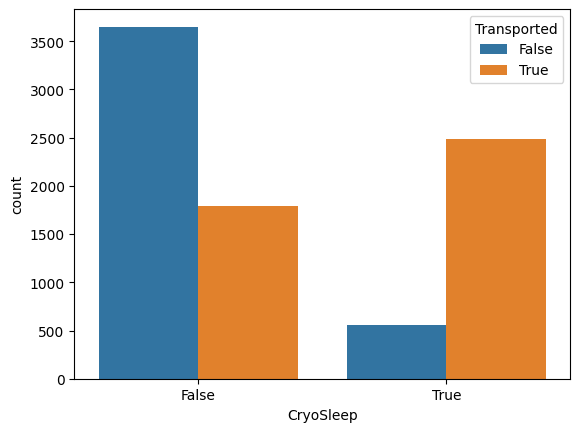

In [ ]:
sns.countplot(data=train_df, x='CryoSleep', hue='Transported')

In [ ]:
train_df[['CryoSleep', 'HomePlanet', 'Destination']].value_counts()

CryoSleep  HomePlanet  Destination  
False      Earth       TRAPPIST-1e      2246
           Mars        TRAPPIST-1e       906
True       Earth       TRAPPIST-1e       819
False      Europa      TRAPPIST-1e       728
True       Mars        TRAPPIST-1e       586
False      Earth       55 Cancri e       474
True       Europa      TRAPPIST-1e       466
                       55 Cancri e       450
False      Europa      55 Cancri e       425
True       Earth       PSO J318.5-22     356
False      Earth       PSO J318.5-22     349
True       Earth       55 Cancri e       207
False      Mars        55 Cancri e       113
True       Mars        55 Cancri e        78
False      Mars        PSO J318.5-22      37
True       Mars        PSO J318.5-22      11
False      Europa      PSO J318.5-22      10
True       Europa      PSO J318.5-22       9
dtype: int64

In [ ]:
apply_group_na('CryoSleep', train_df)


In [ ]:
train_df[['CryoSleep', 'HomePlanet', 'Destination']].value_counts()

CryoSleep  HomePlanet  Destination  
False      Earth       TRAPPIST-1e      2255
           Mars        TRAPPIST-1e       911
True       Earth       TRAPPIST-1e       845
False      Europa      TRAPPIST-1e       734
True       Mars        TRAPPIST-1e       600
           Europa      TRAPPIST-1e       483
False      Earth       55 Cancri e       479
True       Europa      55 Cancri e       460
False      Europa      55 Cancri e       432
True       Earth       PSO J318.5-22     358
False      Earth       PSO J318.5-22     351
True       Earth       55 Cancri e       211
False      Mars        55 Cancri e       114
True       Mars        55 Cancri e        79
False      Mars        PSO J318.5-22      37
True       Mars        PSO J318.5-22      12
False      Europa      PSO J318.5-22      10
True       Europa      PSO J318.5-22       9
dtype: int64

In [ ]:
train_df_copy = train_df.copy()

In [ ]:
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Deck', 'Side', 'PassengerGroup', 'HaveGroup',
       'CabinNum', 'Youth', 'Spending'],
      dtype='object')

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,B,P,0001,False,0,Norm,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,F,S,0002,False,0,Norm,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,A,S,0003,True,0,Old,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,A,S,0003,True,0,Norm,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,F,S,0004,False,1,Norm,1091.0


## Дерево 3

In [ ]:
tree_second = DecisionTreeClassifier(random_state=17)

In [ ]:
tree_params = {"max_depth": list(range(1, 15)), "min_samples_leaf": list(range(1, 15))}

In [ ]:
tree_gscv = GridSearchCV(tree_second, tree_params, cv=5, n_jobs=-1)

In [ ]:
tree_gscv.fit(X_new_train, y_new_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14]})

In [ ]:
tree_gscv.best_estimator_

DecisionTreeClassifier(max_depth=9, min_samples_leaf=10, random_state=17)

In [ ]:
np.mean(cross_val_score(tree_gscv.best_estimator_, X_new_train, y_new_train, cv=5))

0.7897707231040564

In [ ]:
X_new_train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HaveGroup,HomePlanet_Earth,...,Deck_F,Deck_G,Deck_T,Deck_n,Side_P,Side_S,Side_n,Youth_Norm,Youth_Old,Youth_baby
8643,True,50.0,False,0.0,0.0,0.0,0.0,0.0,False,0,...,1,0,0,0,0,1,0,1,0,0
4970,False,7.0,False,0.0,0.0,0.0,0.0,0.0,True,1,...,0,1,0,0,1,0,0,1,0,0
2667,True,40.0,False,0.0,0.0,0.0,0.0,0.0,True,0,...,0,0,0,0,0,1,0,1,0,0
1583,True,26.0,False,0.0,0.0,0.0,0.0,0.0,False,1,...,0,1,0,0,1,0,0,1,0,0
8197,True,25.0,False,0.0,0.0,0.0,0.0,0.0,False,0,...,1,0,0,0,0,1,0,1,0,0


In [ ]:
train_df.groupby(train_df['CryoSleep'].isnull()).mean()

<ipython-input-315-f1af59a11f98>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df.groupby(train_df['CryoSleep'].isnull()).mean()


,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup,Spending
CryoSleep,,,,,,,,,,
False,28.767761,0.022944,218.942348,450.871186,169.743303,304.792453,298.396809,0.504426,0.45283,1442.746098
True,30.598131,0.018692,305.626168,252.869159,155.850467,288.252336,287.429907,0.439252,0.00000,1290.028037


## CryoSleep заполнение


In [ ]:
train_df.loc[train_df['CryoSleep'] == True]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,...,NaN,Candra Jacostaffey,True,G,S,0006,True,0,Norm,0.0
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,...,0.0,Erraiam Flatic,True,B,P,0008,True,1,Norm,0.0
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,...,0.0,Altardr Flatic,True,B,P,0008,True,1,Norm,0.0
18,0016_01,Mars,True,F/5/P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,...,0.0,Alus Upead,True,F,P,0016,False,5,Norm,0.0
21,0020_01,Earth,True,E/0/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,...,0.0,Almary Brantuarez,False,E,S,0020,True,0,baby,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679,9267_02,Europa,True,E/607/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,...,0.0,Sabi Opshaft,True,E,S,9267,True,607,Norm,0.0
8680,9268_01,Earth,True,G/1505/P,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,...,0.0,Agnesa Baldson,True,G,P,9268,False,1505,Norm,0.0
8681,9270_01,Earth,True,G/1497/S,55 Cancri e,33.0,False,0.0,0.0,0.0,...,0.0,Lan Mckinsond,True,G,S,9270,False,1497,Norm,0.0
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,...,0.0,Chelsa Bullisey,True,G,P,9274,False,1508,Norm,0.0


<Axes: xlabel='Deck', ylabel='count'>

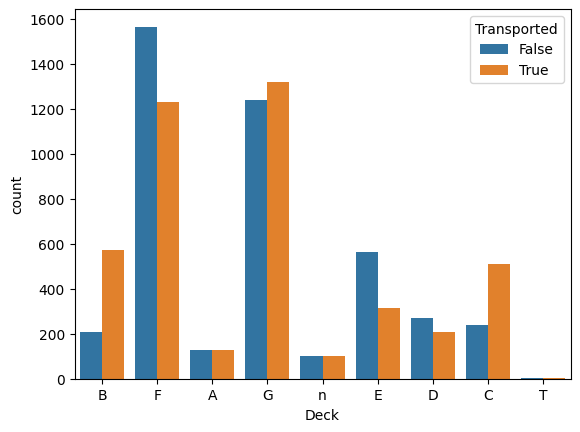

In [ ]:
sns.countplot(data=train_df, x='Deck', hue='Transported')

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0001,False,0,Norm
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,0002,False,0,Norm
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,0003,True,0,Old
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,0003,True,0,Norm
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,0004,False,1,Norm


In [ ]:
train_df['Spending'] = train_df[['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [ ]:
train_df.loc[train_df['CryoSleep'].isna()].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,...,131.0,Carry Cleachrand,False,F,P,0105,False,21,Norm,703.0
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,...,NaN,Rohs Pead,True,F,P,0115,False,24,Norm,0.0
152,0173_01,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,...,0.0,Hilip Grifford,True,E,S,0173,False,11,Old,990.0
175,0198_01,Earth,NaN,G/30/P,PSO J318.5-22,52.0,False,0.0,0.0,0.0,...,0.0,Jeroy Cookson,True,G,P,0198,False,30,Old,0.0
224,0241_01,Europa,NaN,E/11/P,55 Cancri e,33.0,False,0.0,1249.0,0.0,...,1116.0,Alas Dischod,False,E,P,0241,False,11,Norm,7177.0


In [ ]:
train_df.loc[train_df['CryoSleep'].isna() & (train_df['Spending'] == 0), 'CryoSleep'] = True
train_df.loc[train_df['CryoSleep'].isna() & (train_df['Spending'] > 0), 'CryoSleep'] = False

In [ ]:
train_df.loc[train_df['CryoSleep'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending


## Дерево с заполненным CryoSleep

In [ ]:
dele = ['PassengerId', 'Cabin', 'PassengerGroup',
       'CabinNum', 'Spending']
dumm = ['HomePlanet', 'Destination', 'Deck', 'Side', 'Youth']
X_new_train, X_new_valid, y_new_train, y_new_valid = ready_for_tree_traintest(dele, dumm, train_df, delete_na = True, target='Transported')

In [ ]:
X_new_train.head()


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HaveGroup,HomePlanet_False,...,Deck_T,Deck_n,Side_False,Side_P,Side_S,Side_n,Youth_False,Youth_Norm,Youth_Old,Youth_baby
4988,False,21.0,False,751.0,5.0,0.0,1.0,0.0,False,0,...,0,0,0,0,1,0,0,1,0,0
2559,False,52.0,False,758.0,0.0,356.0,5.0,0.0,False,0,...,0,0,0,1,0,0,0,0,1,0
1024,True,33.0,False,0.0,0.0,0.0,0.0,0.0,True,0,...,0,0,0,1,0,0,0,1,0,0
2338,True,28.0,False,0.0,0.0,0.0,0.0,0.0,True,0,...,0,0,0,1,0,0,0,1,0,0
4550,False,21.0,False,12.0,1855.0,0.0,1381.0,358.0,True,0,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
tree_third = DecisionTreeClassifier(random_state=17)

In [ ]:
tree_params = {"max_depth": list(range(1, 15)), "min_samples_leaf": list(range(1, 15))}

In [ ]:
tree_gscv = GridSearchCV(tree_third, tree_params, cv=5, n_jobs=-1)

In [ ]:
tree_gscv.fit(X_new_train, y_new_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14]})

In [ ]:
tree_gscv.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=17)

In [ ]:
np.mean(cross_val_score(tree_gscv.best_estimator_, X_new_train, y_new_train, cv=5))

0.7940118685772182

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,B,P,0001,False,0,Norm,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,F,S,0002,False,0,Norm,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,A,S,0003,True,0,Old,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,A,S,0003,True,0,Norm,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,F,S,0004,False,1,Norm,1091.0


In [ ]:
train_df.isna().sum()

PassengerId         0
HomePlanet        109
CryoSleep           0
Cabin              99
Destination       103
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              200
Transported         0
Deck                0
Side                0
PassengerGroup      0
HaveGroup           0
CabinNum           99
Youth               0
Spending            0
dtype: int64

## Заполнение трат
1. Логичнее заполнять VIP по квартилям
2. Траты необходимо заполнять по медиане (не считая тех, у кого Cryosleep = True)

In [ ]:
train_df.loc[(train_df['CryoSleep'] == False) & (train_df['VIP'] == True)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,A,S,0003,True,0,Old,10383.0
108,0112_01,Europa,False,B/1/S,55 Cancri e,48.0,True,0.0,2537.0,87.0,...,13.0,Moth Cowtale,True,B,S,0112,False,1,Norm,2654.0
120,0128_01,Mars,False,D/3/S,TRAPPIST-1e,61.0,True,2353.0,334.0,9.0,...,2.0,Grohs Fles,False,D,S,0128,True,3,Old,3014.0
214,0224_01,Mars,False,F/42/S,TRAPPIST-1e,32.0,True,181.0,0.0,5.0,...,0.0,Blues Queen,False,F,S,0224,False,42,Norm,1820.0
291,0321_01,NaN,False,F/61/S,TRAPPIST-1e,59.0,True,1018.0,0.0,209.0,...,0.0,Quites Bache,False,F,S,0321,False,61,Old,1227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,9057_01,Europa,False,B/296/P,55 Cancri e,36.0,True,132.0,3479.0,0.0,...,0.0,Coxan Statch,False,n,n,9057,True,296,Norm,7397.0
8614,9194_02,Europa,False,E/603/S,TRAPPIST-1e,32.0,True,1003.0,909.0,0.0,...,15.0,Tachba Subwor,False,E,S,9194,True,603,Norm,1927.0
8621,9197_02,Europa,False,C/308/P,TRAPPIST-1e,41.0,True,0.0,7964.0,0.0,...,5839.0,Aludram Platch,False,C,P,9197,True,308,Norm,17041.0
8652,9230_01,Europa,False,C/342/S,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,...,971.0,NaN,True,C,S,9230,False,342,Norm,10154.0


In [ ]:
train_df.loc[train_df['PassengerId'] == '0402_01', 'HomePlanet'] = 'Europa'

## Поработаем с кабинами

In [ ]:
train_df.loc[train_df['HomePlanet'] == 'Mars'].sample(frac=1).head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
7019,7472_01,Mars,True,F/1426/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,NaN,NaN,True,F,S,7472,False,1426,Norm,0.0
5845,6186_01,Mars,False,E/396/P,TRAPPIST-1e,19.0,True,61.0,783.0,110.0,...,0.0,Tot Ancy,True,E,P,6186,False,396,Norm,954.0
6447,6810_01,Mars,True,E/450/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,...,0.0,Yots Knik,True,E,S,6810,True,450,Norm,0.0
802,0848_02,Mars,True,F/175/P,TRAPPIST-1e,14.0,False,0.0,0.0,0.0,...,0.0,Monam Raca,True,F,P,0848,True,175,Norm,0.0
3669,3940_01,Mars,False,D/132/P,TRAPPIST-1e,60.0,True,2739.0,0.0,0.0,...,0.0,Trisp Apie,False,D,P,3940,False,132,Old,2739.0
2141,2299_01,Mars,False,F/448/S,TRAPPIST-1e,35.0,False,174.0,0.0,381.0,...,62.0,Wealke Ramad,False,F,S,2299,False,448,Norm,617.0
3152,3402_01,Mars,False,E/231/S,TRAPPIST-1e,21.0,False,2.0,0.0,898.0,...,0.0,Toal Ban,False,E,S,3402,False,231,Norm,1048.0
8294,8860_01,Mars,True,F/1825/P,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,...,0.0,Turs Mity,True,F,P,8860,True,1825,Norm,0.0
6241,6603_01,Mars,False,D/208/P,TRAPPIST-1e,25.0,False,68.0,0.0,3700.0,...,0.0,Beres Conca,True,D,P,6603,False,208,Norm,3768.0
2657,2843_01,Mars,False,E/175/P,TRAPPIST-1e,50.0,False,357.0,0.0,657.0,...,0.0,Apsps Terte,False,E,P,2843,False,175,Norm,1014.0


<Axes: xlabel='Deck', ylabel='count'>

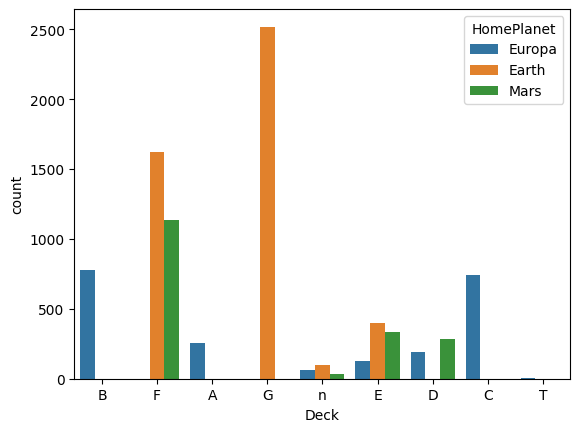

In [ ]:
sns.countplot(data=train_df, x='Deck', hue='HomePlanet')

- На палубах C, B, A ехали только Европейцы.
- На палубе G ехали только земляне.
- На палебе F находились как земляне, так и марсиане.

<Axes: xlabel='Deck', ylabel='count'>

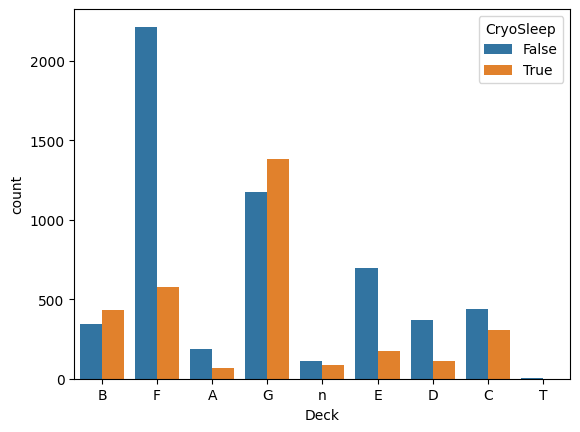

In [ ]:
sns.countplot(data=train_df, x='Deck', hue='CryoSleep')

In [ ]:
train_df.Deck.value_counts()

F    2868
G    2559
E     876
B     779
C     768
D     478
A     256
n     104
T       5
Name: Deck, dtype: int64

In [ ]:
train_df.loc[train_df['Cabin'].isna()].HomePlanet.value_counts()

Earth     55
Europa    21
Mars      19
Name: HomePlanet, dtype: int64

### Заполню Кабины по большинству

In [ ]:
train_df.loc[train_df['Cabin'].isna() & (train_df['HomePlanet'] == 'Mars'), 'Deck'] = 'F'

In [ ]:
train_df.loc[train_df['Cabin'].isna() & (train_df['HomePlanet'] == 'Earth'), 'Deck'] = 'F'

In [ ]:
train_df.loc[train_df['Cabin'].isna() & (train_df['HomePlanet'] == 'Europa'), 'Deck'] = 'C'

In [ ]:
train_df.isnull().sum()

PassengerId         0
HomePlanet        108
CryoSleep           0
Cabin              99
Destination       103
Age                 0
VIP                 0
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
Deck                0
Side                0
PassengerGroup      0
HaveGroup           0
CabinNum           99
Youth               0
Spending            0
dtype: int64

In [ ]:
def home_planet(df):
  df.loc[df['HomePlanet'].isna() & df['Deck'] == 'G', 'HomePlanet'] = 'Earth'
  df.loc[df['HomePlanet'].isna() & df['Deck'] == 'C', 'HomePlanet'] = 'Europa'
  df.loc[df['HomePlanet'].isna() & df['Deck'] == 'B', 'HomePlanet'] = 'Europa'
  df.loc[df['HomePlanet'].isna() & df['Deck'] == 'A', 'HomePlanet'] = 'Europa'


In [ ]:
train_df.loc[train_df['HomePlanet'].isna() & train_df['Deck'] == 'G', 'HomePlanet'] = 'Earth'
train_df.loc[train_df['HomePlanet'].isna() & train_df['Deck'] == 'C', 'HomePlanet'] = 'Europa'
train_df.loc[train_df['HomePlanet'].isna() & train_df['Deck'] == 'B', 'HomePlanet'] = 'Europa'
train_df.loc[train_df['HomePlanet'].isna() & train_df['Deck'] == 'A', 'HomePlanet'] = 'Europa'

In [ ]:
train_df.isnull().sum()

PassengerId         0
HomePlanet          0
CryoSleep           0
Cabin              99
Destination         0
Age                 0
VIP                 0
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
Deck                0
Side                0
PassengerGroup      0
HaveGroup           0
CabinNum           99
Youth               0
Spending            0
dtype: int64

<Axes: xlabel='Destination', ylabel='count'>

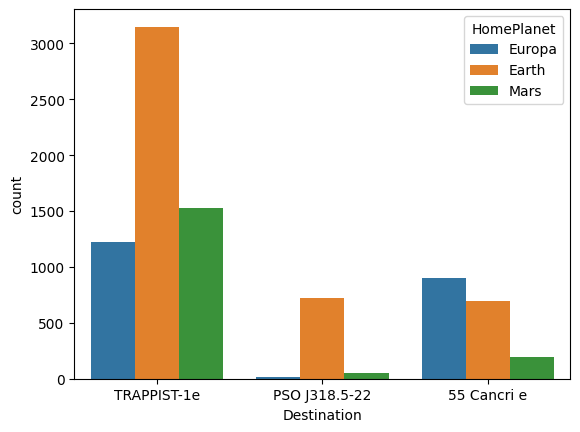

In [ ]:
sns.countplot(data=train_df, x='Destination', hue='HomePlanet')

In [ ]:
train_df.loc[train_df['Destination'].isna(), 'Destination'] = 'TRAPPIST-1e'

In [ ]:
train_df.loc[train_df['HomePlanet'].isna(), 'HomePlanet'] = 'Earth'

In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,B,P,0001,False,0,Norm,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,F,S,0002,False,0,Norm,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,A,S,0003,True,0,Old,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,A,S,0003,True,0,Norm,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,F,S,0004,False,1,Norm,1091.0


In [ ]:
train_df.iloc[91:95]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
91,0099_01,Earth,False,F/19/P,PSO J318.5-22,23.0,False,311.0,427.0,526.0,...,0.0,Aliey Leetersoney,False,F,P,0099,True,19,Norm,1301.0
92,0099_02,Earth,False,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,...,0.0,Thewis Connelson,True,G,P,0099,True,12,baby,0.0
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,...,0.0,Book Trad,True,n,n,0101,False,NaN,Norm,0.0
94,0102_01,Earth,False,F/23/S,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,...,91.0,Ritany Holson,False,F,S,0102,False,23,Norm,921.0


In [ ]:
train_df.loc[train_df['Cabin'] == 'F/1/P']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Side,PassengerGroup,HaveGroup,CabinNum,Youth,Spending
12,0009_01,Mars,False,F/1/P,TRAPPIST-1e,32.0,False,73.0,0.0,1123.0,...,113.0,Berers Barne,True,F,P,0009,False,1,Norm,1309.0


<Axes: xlabel='Deck', ylabel='count'>

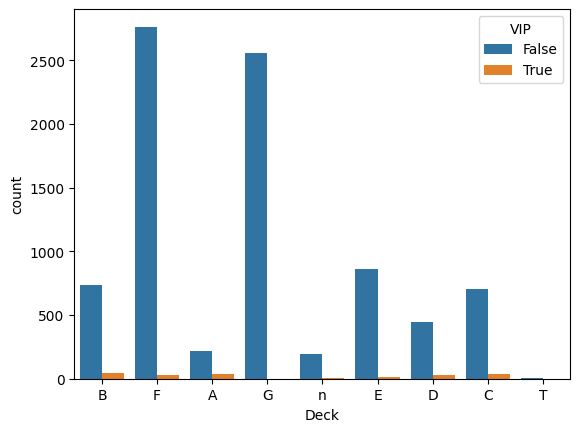

In [ ]:
sns.countplot(data=df, x='Deck', hue='VIP')

<Axes: xlabel='Deck', ylabel='count'>

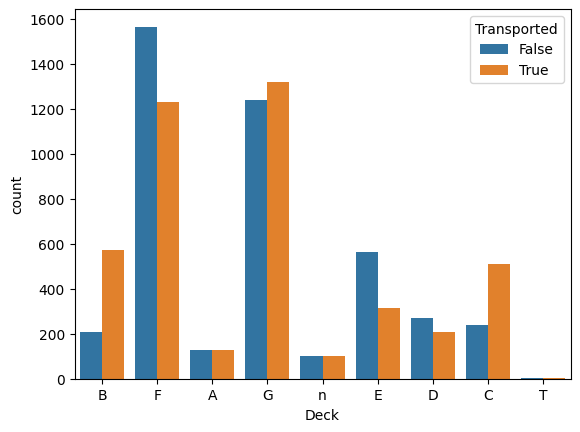

In [ ]:
sns.countplot(data=df, x='Deck', hue='Transported')

<Axes: xlabel='Deck', ylabel='count'>

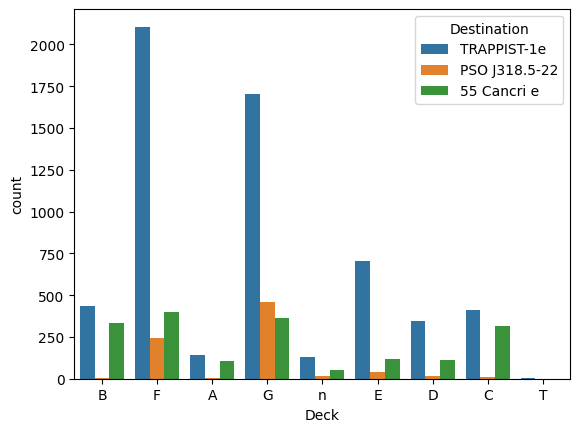

In [ ]:
sns.countplot(data=df, x='Deck', hue='Destination')

In [ ]:
train_df.loc[train_df['Age'] < 13, 'Spending'].describe()

count    806.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Spending, dtype: float64

In [ ]:
def fill_na_money(df, column):
  train_df.loc[train_df["Age"] < 13, column] = train_df.loc[train_df["Age"] < 13, column].fillna(0)
  train_df.loc[train_df["Spending" == 0]]
  train_df.loc[train_df["Age"] >= 13, column] = train_df.loc[train_df["Age"] >= 13, column].fillna(train_df[column].median())

In [ ]:
train_df[['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']] = train_df[['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

In [ ]:
train_df['VIP'].fillna(False, inplace=True)

In [ ]:
train_df['CryoSleep'].value_counts()

False    5622
True     3071
Name: CryoSleep, dtype: int64

In [ ]:
tree_valid_pred = tree_gscv.predict(X_new_valid)

In [ ]:
accuracy_score(y_new_valid, tree_valid_pred)

0.7861111111111111

In [ ]:
train_df.isnull().sum()

PassengerId         0
HomePlanet        106
CryoSleep           0
Cabin              96
Destination       100
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              199
Transported         0
Deck                0
Side                0
PassengerGroup      0
HaveGroup           0
CabinNum           96
Youth               0
Spending            0
dtype: int64

In [ ]:
new_df.loc[new_df['Age'].isna(), 'Age'] = new_df.loc[new_df['Age'].isna(), 'Deck'].map(new_df[['Deck', 'Age']].groupby('Deck').agg('mean')['Age'])

In [ ]:
groupby = concatenated_df[['Deck', 'Age']].groupby('Deck').agg('median')['Age']

In [ ]:
groupby

Deck
A    35.484330
B    33.502199
C    34.700364
D    33.446779
E    30.241194
F    28.364006
G    23.934028
T    35.545455
n    30.354839
Name: Age, dtype: float64

In [ ]:
concatenated_df.loc[concatenated_df['Age'].isna(), 'Deck'].map(groupby)

50       23.934028
64       30.241194
137      23.934028
181      35.484330
184      34.700364
           ...    
12873    28.364006
12909    23.934028
12922    34.700364
12967    33.446779
12968    33.446779
Name: Deck, Length: 270, dtype: float64

# Функция для подготовки дф

1. Проставить по полю "HaveGroup": 'Destination', 'Cabin', 'HomePlanet'
2. На основе 'Spending' = 0 проставить 'CryoSleep' = True
3. Пропущенные 'HomePlanet' & 'Destination' заполняем по большинству: 'Earth' &  'TRAPPIST-1e'
4. Пропущенные 'VIP' = False
5. Пропущенный возраст заполняем медианой
6. Пропущенные значения трат заполняем 0, если 'Spending' = 0, иначе медианой
7. Оставить в покое пропущенные кабины как n для первого прогона
8. Удалить все лишние колонки.


7. Пропущенные значения кабин также по большинству. (см. выше)
train_df.loc[train_df['Cabin'].isna() & (train_df['HomePlanet'] == 'Mars'), 'Deck'] = 'F'
8. Пропущенную сторону надо смотреть.

In [ ]:
def apply_group_na(column, df, id_column='PassengerId'):
  if 'HaveGroup' not in df.columns:
    df['HaveGroup'] = df[id_column].apply(lambda x: int(str(x).split('_')[0])).duplicated(False)
    df['PassengerGroup'] = df['PassengerId'].apply(lambda x: str(x).split('_')[0])

  groups_wo_column = df.loc[(df[column].isna()) & (df['HaveGroup'] == True)]['PassengerGroup']
  filled_na_column = df.loc[df['PassengerGroup'].isin(groups_wo_column)][['PassengerGroup', column]].sort_values(by=['PassengerGroup', column])[column].interpolate(method='pad')
  df.loc[df[column].isna(), column] = df.loc[df[column].isna()].index.map(filled_na_column)


In [ ]:
def standart_PCA__it(X_train, X_valid=pd.DataFrame(), pca_comp=20, pca=True):
  ss = StandardScaler()
  X_train_scaled = ss.fit_transform(X_train)
  if not X_valid.empty:
    X_valid_scaled = ss.transform(X_valid)
  if pca:
    pca = PCA(n_components=pca_comp)
    pca.fit(X_train_scaled)
    X_train_scaled_pca = pca.transform(X_train_scaled)
    if not X_valid.empty:
      X_valid_scaled_pca = pca.transform(X_valid_scaled)
      return X_train_scaled_pca, X_valid_scaled_pca
    return X_train_scaled_pca
  if not X_valid.empty:
    return X_train_scaled, X_valid_scaled
  return X_train_scaled

In [ ]:
def do_job(df, target='Transported', group_apply=[], delete=[],
           dummies=[], id_column='PassengerId',
           train_test=False, return_df = False, improved_age = True, st_pca = False, not_alone=False, pca=True,
           improved_age_func='median', age = 11):
  #Проверка на целостность листов
  if not group_apply:
    group_apply=['Destination', 'Cabin', 'HomePlanet']
  if not delete:
    delete=['PassengerId', 'PassengerGroup']
  if not dummies:
    dummies=['HomePlanet', 'Side', 'Deck', 'Destination']

  #Дропну имя, нахер нужно
  new_df = df.drop('Name', axis=1)

  #Проставим групповые значения, если у пассажира есть группа.
  for column in group_apply:
    apply_group_na(column=column, df=new_df)

  #Создам колонку трат, если траты = 0, то чувак спит, иначе бодрствует (к слову, тут не учитывается возраст. Если товарищу <13 лет, его траты 0, но не факт, что он спит. Но бесят дети без группы, их надо поисследовать отдельно)
  new_df['Spending'] = new_df[['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
  new_df.loc[new_df['CryoSleep'].isna() & (new_df['Spending'] == 0), 'CryoSleep'] = True
  new_df.loc[new_df['CryoSleep'].isna(), 'CryoSleep'] = False

  #Пропущенные 'HomePlanet' & 'Destination' заполняем по большинству: 'Earth' &  'TRAPPIST-1e'
  new_df.loc[new_df['HomePlanet'].isna(), 'HomePlanet'] = 'Earth'
  new_df.loc[new_df['Destination'].isna(), 'Destination'] = 'TRAPPIST-1e'

  #Пропущенные VIP = False
  new_df.loc[new_df['VIP'].isna(), 'VIP'] = False

  #Заполним деньги. Если траты=0, то na=0, иначе na=медиана
  money_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
  for column in money_columns:
    new_df.loc[new_df[column].isna() & (new_df['Spending'] == 0), column] = 0
    new_df.loc[new_df[column].isna(), column] = new_df[column].median()

   #Проставим сторону и палубу. Оставим n как есть на первый раз.
  new_df['Side'] = new_df['Cabin'].apply(lambda x: str(x)[-1])
  new_df['Deck'] = new_df['Cabin'].apply(lambda x: str(x)[0])

  #Проставлю "один в комнате"
  if not_alone:
    new_df['NotAlone'] = new_df['Cabin'].duplicated(keep=False)

  new_df.drop('Cabin', axis=1, inplace=True)

  #Заполню возраст медианой
  if not improved_age:
    new_df.loc[new_df['Age'].isna(), 'Age'] = new_df['Age'].median()

  if improved_age:
    children = new_df['Age'].isna() & (new_df['Spending'] == 0) & (new_df['CryoSleep'] == False) & (new_df['Deck'].isin(['G', 'E', 'F']))
    new_df.loc[children, 'Age'] = age
    new_df.loc[new_df['Age'].isna(), 'Age'] = new_df.loc[new_df['Age'].isna(), 'Deck'].map(new_df[['Deck', 'Age']].groupby('Deck').agg(improved_age_func)['Age'])


  #Get_dummies
  for column in dummies:
    new_df = pd.concat([new_df, pd.get_dummies(new_df[column], prefix = column)], axis=1)

  delete.extend(dummies)

  if not return_df:
    delete.append(target)
    y = new_df[target]

  X = new_df.drop(delete, axis=1)

  if train_test:
    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
    y = new_df[target]
    if not st_pca:
      return train_test_split(X, y, test_size=0.3)
    if st_pca:
      X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
      X_train_scaled_pca, X_valid_scaled_pca = standart_PCA__it(X_train, X_valid, pca=pca)
      return X_train_scaled_pca, X_valid_scaled_pca, y_train, y_valid

  if not return_df:
    return X, y


  return X

In [ ]:
X_train, X_valid, y_train, y_valid = do_job(df = train_df_func.copy(), train_test=True, delete=['PassengerId', 'PassengerGroup', 'Spending'])
X_train.sample(n=5)


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HaveGroup,HomePlanet_Earth,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
3392,True,22.0,False,0.0,0.0,0.0,0.0,0.0,False,0,...,1,0,0,0,0,0,0,1,0,0
5704,False,16.0,False,805.0,4.0,0.0,0.0,0.0,False,1,...,0,0,0,0,1,0,0,0,0,1
3277,False,26.0,False,0.0,597.0,0.0,0.0,212.0,True,1,...,0,0,0,0,1,0,0,0,0,1
232,False,33.0,False,0.0,1.0,0.0,8620.0,1063.0,False,0,...,1,0,0,0,0,0,0,0,0,1
3071,False,19.0,False,260.0,0.0,238.0,139.0,8.0,False,1,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
func_tree = DecisionTreeClassifier(random_state=17)

In [ ]:
tree_params = {"max_depth": list(range(1, 15)), "min_samples_leaf": list(range(1, 15))}

In [ ]:
func_tree_gscv = GridSearchCV(func_tree, tree_params, cv=5, n_jobs=-1)

In [ ]:
func_tree_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14]})

In [ ]:
func_tree_gscv.best_estimator_

DecisionTreeClassifier(max_depth=11, min_samples_leaf=14, random_state=17)

In [ ]:
np.mean(cross_val_score(func_tree_gscv.best_estimator_, X_train, y_train, cv=5))

0.7916187345932622

In [ ]:
tree_valid_pred = func_tree_gscv.predict(X_valid)

In [ ]:
accuracy_score(y_valid, tree_valid_pred)

0.7818251533742331

# Обучение дерева для kaggle

### Обучаю первое kaggle дерево

In [ ]:
kaggle_tree = DecisionTreeClassifier(random_state=17)

In [ ]:
tree_params = {"max_depth": list(range(1, 15)), "min_samples_leaf": list(range(1, 15))}

In [ ]:
tree_kaggle_gscv = GridSearchCV(kaggle_tree, tree_params, cv=5, n_jobs=-1)

In [ ]:
new_X, new_y = do_job(df = train_df_func.copy())

In [ ]:
tree_kaggle_gscv.fit(new_X, new_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14]})

In [ ]:
tree_kaggle_gscv.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=9, random_state=17)

In [ ]:
np.mean(cross_val_score(tree_kaggle_gscv.best_estimator_, new_X, new_y, cv=5))

0.7838512140424341

### Подгоняю test_df

In [ ]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Side,HaveGroup,PassengerGroup
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,S,False,0001
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,S,False,0002
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,S,False,0003
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,S,False,0003
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,S,False,0004


In [ ]:
test_df_new = do_job(df = test_df, return_df = True)

In [ ]:
tree_valid_pred = tree_kaggle_gscv.predict(test_df_new)

In [ ]:
tree_valid_pred

array([ True, False,  True, ...,  True, False,  True])

In [ ]:
train_num = len(tree_valid_pred)

In [ ]:
tree_first_pred = pd.DataFrame(tree_valid_pred, index=test_df['PassengerId'], columns=['Transported'])

In [ ]:
tree_first_pred.to_csv('pred_titanic_1.csv')

# Пробую лес

In [ ]:
X_train, X_valid, y_train, y_valid = do_job(df = train_df_func.copy(), train_test=True, delete=['PassengerId', 'PassengerGroup'])
X_train.sample(n=5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HaveGroup,Spending,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
4742,False,29.0,True,530.0,418.0,0.0,0.0,9129.0,True,10077.0,...,1,0,0,0,0,0,0,1,0,0
1114,True,64.0,False,0.0,0.0,0.0,0.0,0.0,True,0.0,...,0,0,0,1,0,0,0,1,0,0
1418,False,17.0,False,0.0,55.0,913.0,0.0,55.0,True,1023.0,...,0,0,0,0,1,0,0,1,0,0
2016,False,45.0,False,2138.0,0.0,0.0,659.0,0.0,False,2797.0,...,0,0,0,1,0,0,0,0,0,1
2003,True,13.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0,0,0,0,1,0,0,1,0,0


## Заскейлим данные для PCA

In [ ]:
ss = StandardScaler()

In [ ]:
X_train_scaled = ss.fit_transform(X_train)
X_valid_scaled = ss.transform(X_valid)
y_train = np.array(y_train)

## Сам лес

In [ ]:
#first_forest = RandomForestClassifier(n_estimators=100,
 #                              bootstrap = True,
  #                             max_features = 'sqrt', random_state=17)
first_forest = RandomForestClassifier()

In [ ]:
first_forest.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [ ]:
display(first_forest.score(X_train_scaled, y_train))

0.9580936729663106

## FeatureImportances

In [ ]:
feats = {}
for feature, importance in zip(X_train.columns, first_forest.feature_importances_):
  feats[feature] = importance

In [ ]:
feats

{'CryoSleep': 0.07688130170575466,
 'Age': 0.17282858917992255,
 'VIP': 0.00245106442615974,
 'RoomService': 0.0785220820900525,
 'FoodCourt': 0.08397329700254301,
 'ShoppingMall': 0.07491047428237553,
 'Spa': 0.09010180569451738,
 'VRDeck': 0.0872440019157473,
 'HaveGroup': 0.016259998274450845,
 'Spending': 0.1540483257590657,
 'HomePlanet_Earth': 0.022233890259448233,
 'HomePlanet_Europa': 0.014412862053110187,
 'HomePlanet_Mars': 0.00935449880771263,
 'Side_P': 0.01177957593281544,
 'Side_S': 0.010724406500158485,
 'Side_n': 0.0009783311608737581,
 'Deck_A': 0.0023768197027648876,
 'Deck_B': 0.005997096981186956,
 'Deck_C': 0.007461229762647302,
 'Deck_D': 0.003709056598529567,
 'Deck_E': 0.014126472937130196,
 'Deck_F': 0.01748195475482459,
 'Deck_G': 0.015364477601221466,
 'Deck_T': 4.197821736820608e-05,
 'Deck_n': 0.0010325203613609148,
 'Destination_55 Cancri e': 0.009272987636237172,
 'Destination_PSO J318.5-22': 0.006316849285497403,
 'Destination_TRAPPIST-1e': 0.01011405111

In [ ]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})

In [ ]:
importances = importances.sort_values(by='Gini-Importance', ascending=False).reset_index()\
    .rename(columns={'index': 'Features'})

Text(0.5, 1.0, 'Feature Importance')

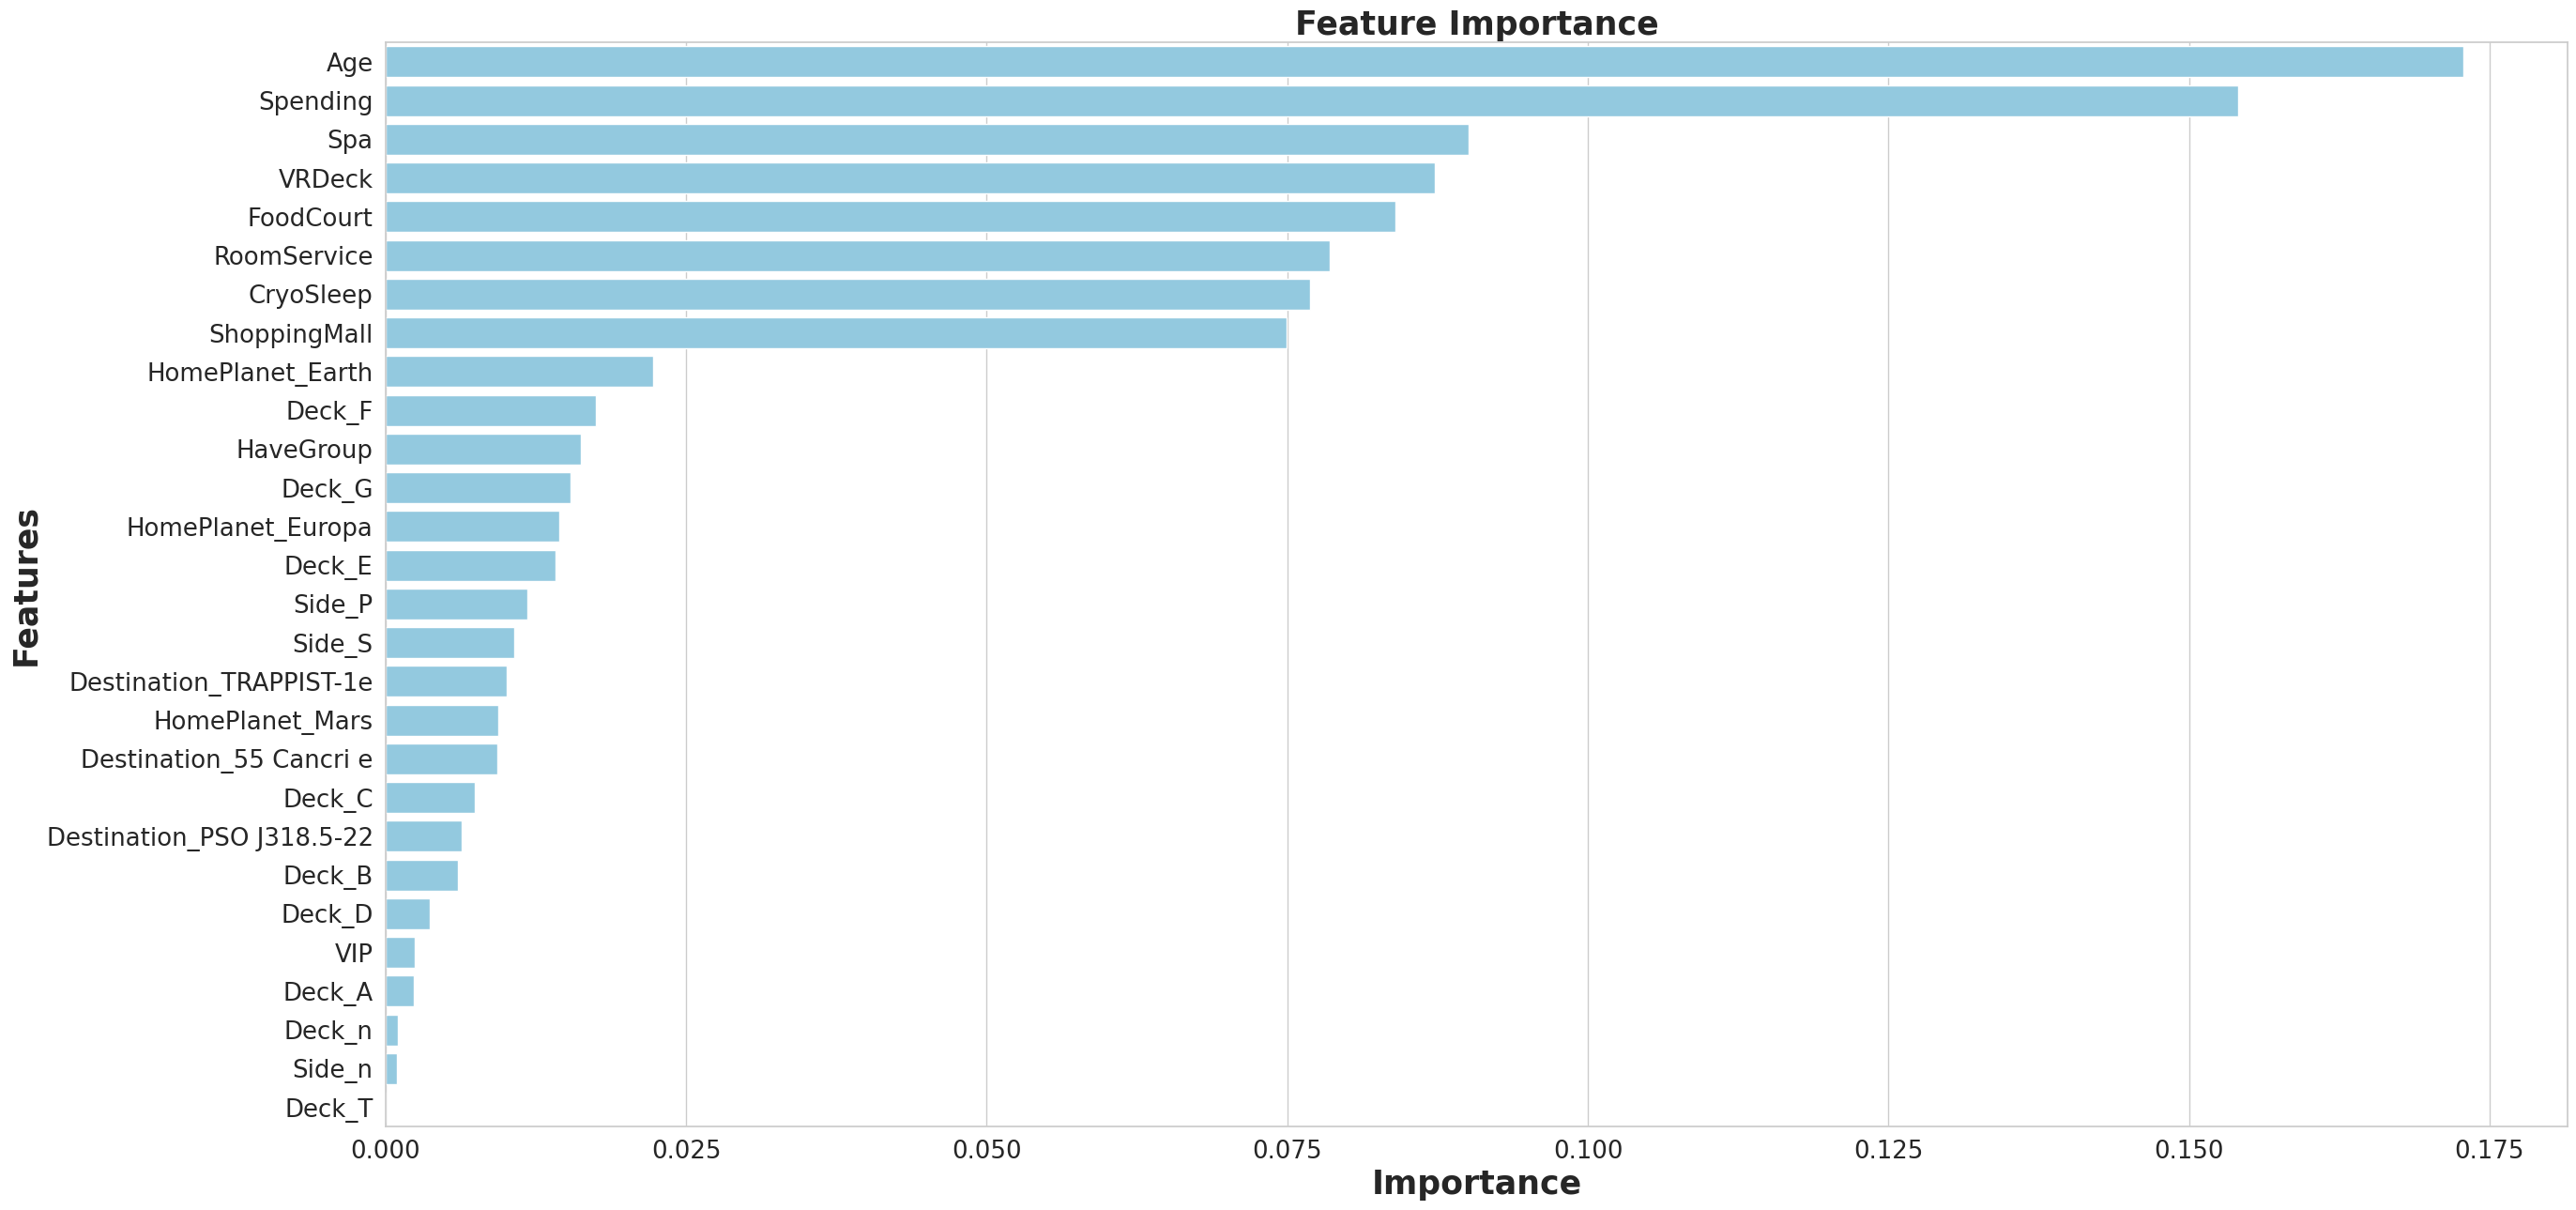

In [ ]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue');
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')

In [ ]:
importances.head(10)

,Features,Gini-Importance
0,Age,0.172829
1,Spending,0.154048
2,Spa,0.090102
3,VRDeck,0.087244
4,FoodCourt,0.083973
5,RoomService,0.078522
6,CryoSleep,0.076881
7,ShoppingMall,0.074910
8,HomePlanet_Earth,0.022234
9,Deck_F,0.017482


In [ ]:
pca_test = PCA(n_components=28)

In [ ]:
pca_test.fit(X_train_scaled)

PCA(n_components=28)

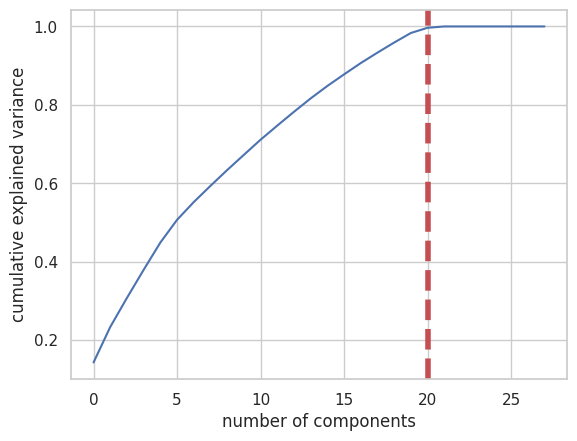

None

In [ ]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=20, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr

In [ ]:
pca_df

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.142352,1.423524e-01
1,0.232934,9.058131e-02
2,0.307134,7.420042e-02
3,0.378797,7.166331e-02
4,0.448396,6.959828e-02
5,0.506363,5.796734e-02
6,0.551686,4.532257e-02
7,0.593065,4.137928e-02
8,0.633370,4.030535e-02
9,0.672251,3.888116e-02


In [ ]:
pca = PCA(n_components=20)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_valid_scaled_pca = pca.transform(X_valid_scaled)

In [ ]:
rfc_2 = RandomForestClassifier()
rfc_2.fit(X_train_scaled_pca, y_train)
display(rfc_2.score(X_train_scaled_pca, y_train))

0.9580936729663106

## Настройка гиперпараметров (RandomGSCV)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

In [ ]:
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rfc_rscv = RandomizedSearchCV(rfc_2,
                        param_dist,
                        n_iter = 100,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)

In [ ]:
rfc_rscv.fit(X_train_scaled_pca, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 7, 12, 18, 23,
                                                             28, 34, 39, 44,
                                                             50],
                                        'min_samples_split': [2, 7, 12, 18, 23,
                                                              28, 34, 39, 44,
                                                              50],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0, verbose=1)

In [ ]:
rfc_rscv.best_params_

{'n_estimators': 300,
 'min_samples_split': 28,
 'min_samples_leaf': 7,
 'max_features': 'log2',
 'max_depth': 13,
 'bootstrap': True}

In [ ]:
rs_df = pd.DataFrame(rfc_rscv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time',
            'std_fit_time',
            'mean_score_time',
            'std_score_time',
            'params',
            'split0_test_score',
            'split1_test_score',
            'split2_test_score',
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,300,28,7,log2,13,True,0.788824,1
1,100,2,18,sqrt,15,False,0.788002,2
2,500,12,18,sqrt,13,False,0.787181,3
3,500,39,18,sqrt,11,False,0.787016,4
4,1000,44,23,log2,12,False,0.786852,5
5,800,28,12,sqrt,14,True,0.786851,6
6,400,23,12,sqrt,11,True,0.786522,7
7,300,2,23,log2,14,False,0.786029,8
8,900,34,18,sqrt,11,True,0.785701,9
9,1000,34,23,sqrt,14,True,0.785537,10


Text(0.5, 1.0, 'bootstrap')

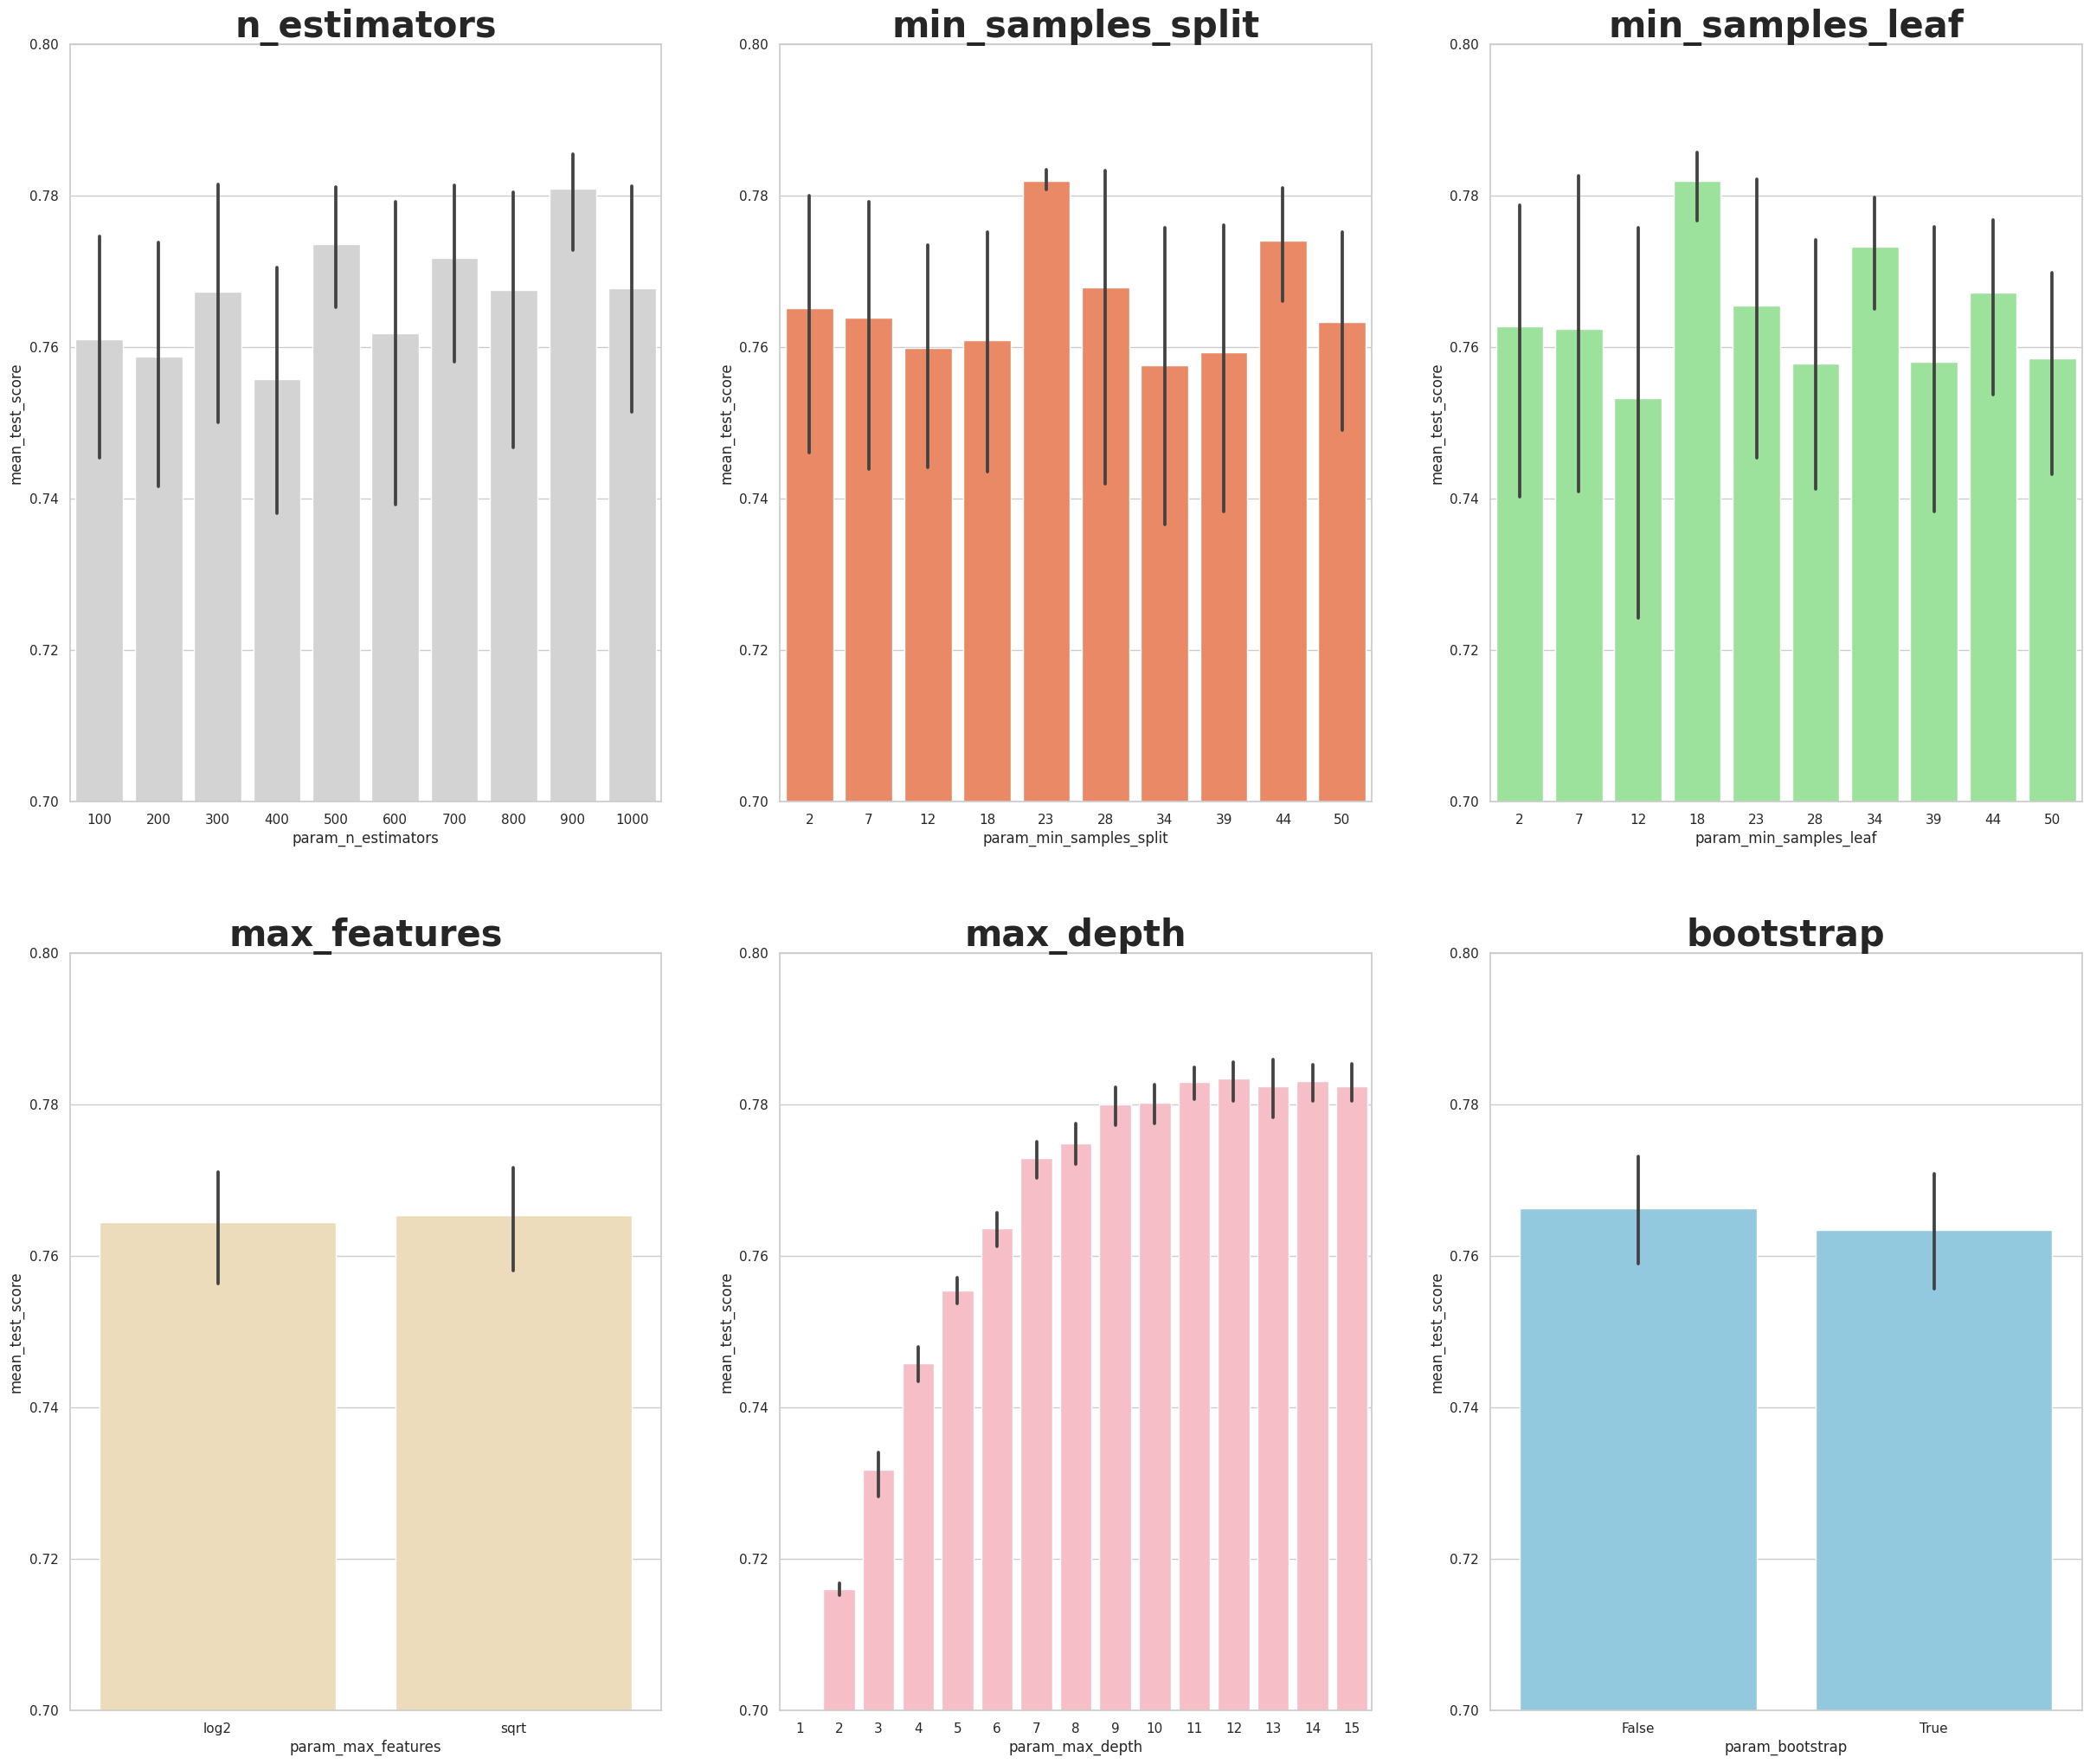

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2)
axis_limits=[.7,.8]
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim(axis_limits)
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim(axis_limits)
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim(axis_limits)
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim(axis_limits)
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim(axis_limits)
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim(axis_limits)
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

## Настройка гиперпараметров (GSCV)

In [ ]:
n_estimators = [900]
max_features = ['sqrt']
max_depth = range(9, 18)
min_samples_split = range(23,30)
min_samples_leaf = range(16, 19)
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
gs = GridSearchCV(rfc_2, param_grid, cv = 3, verbose = 1, n_jobs=-1)

In [ ]:
gs.fit(X_train_scaled_pca, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [9, 15],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 7, 18],
                         'min_samples_split': [23],
                         'n_estimators': [700, 900]},
             verbose=1)

In [ ]:
rfc_3 = gs.best_estimator_
gs.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 18,
 'min_samples_split': 23,
 'n_estimators': 700}

## Проверка моделей на тестовых данных

In [ ]:
y_pred = first_forest.predict(X_valid_scaled)
y_pred_pca = rfc_rscv.predict(X_valid_scaled_pca)
y_pred_gs = gs.best_estimator_.predict(X_valid_scaled_pca)

In [ ]:
print(f"baseline forest: {accuracy_score(y_valid, y_pred)}")
print(f'pca forest: {accuracy_score(y_valid, y_pred_pca)}')
print(f'gscv forest: {accuracy_score(y_valid, y_pred_gs)}')

baseline forest: 0.7906441717791411
pca forest: 0.7963957055214724
gscv forest: 0.7944785276073619


In [ ]:
accuracy_score(y_valid, y_pred)

0.7906441717791411

## Обучу PCA на всей выборке

In [ ]:
X_train, y_train, = do_job(df = train_df.copy(), delete=['PassengerId', 'PassengerGroup'])

In [ ]:
X_train_scaled = ss.fit_transform(X_train)
y_train = np.array(y_train)

In [ ]:
kaggle_forest = RandomForestClassifier()

In [ ]:
kaggle_forest.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [ ]:
display(kaggle_forest.score(X_train_scaled, y_train))

0.9526055446911308

In [ ]:
feats = {}
for feature, importance in zip(X_train.columns, kaggle_forest.feature_importances_):
  feats[feature] = importance

In [ ]:
pca = PCA(n_components=20)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)

In [ ]:
rfc_pca_kaggle = RandomForestClassifier()
rfc_pca_kaggle.fit(X_train_scaled_pca, y_train)
display(rfc_pca_kaggle.score(X_train_scaled_pca, y_train))

0.9526055446911308

In [ ]:
test_df_new = do_job(df = test_df, return_df = True, delete=['PassengerId', 'PassengerGroup'])

In [ ]:
test_df_scaled = ss.fit_transform(test_df_new)

In [ ]:
test_df_new.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HaveGroup,HomePlanet_Earth,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,True,27.0,False,0.0,0.0,0.0,0.0,0.0,False,1,...,0,0,0,0,1,0,0,0,0,1
1,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,False,1,...,0,0,0,1,0,0,0,0,0,1
2,True,31.0,False,0.0,0.0,0.0,0.0,0.0,False,0,...,1,0,0,0,0,0,0,1,0,0
3,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,False,0,...,1,0,0,0,0,0,0,0,0,1
4,False,20.0,False,10.0,0.0,635.0,0.0,0.0,False,1,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
X_test_scaled_pca = pca.transform(test_df_scaled)

In [ ]:
rfc_pca_predict = rfc_pca_kaggle.predict(X_test_scaled_pca)

In [ ]:
rfc_pca_predict

array([ True, False,  True, ...,  True,  True,  True])

In [ ]:
train_num = len(rfc_pca_predict)

In [ ]:
rf_pred = pd.DataFrame(rfc_pca_predict, index=test_df['PassengerId'], columns=['Transported'])

In [ ]:
rf_pred.to_csv('pred_titanic_rf.csv')

In [ ]:
rf_1 = RandomForestClassifier(bootstrap=False,
 max_depth=15,
 max_features='sqrt',
 min_samples_leaf=18,
 min_samples_split=23,
 n_estimators=700)

In [ ]:
rf_1.fit(X_train_scaled_pca, y_train)

RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_leaf=18,
                       min_samples_split=23, n_estimators=700)

In [ ]:
rfc_gscv_predict = rf_1.predict(X_test_scaled_pca)

In [ ]:
rf_gscv_pred = pd.DataFrame(rfc_gscv_predict, index=test_df['PassengerId'], columns=['Transported'])

In [ ]:
rf_gscv_pred.to_csv('rf_gscv_pred.csv')

## Попробуем дерево с новым возрастом

In [ ]:
impr_age_tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=17)

In [ ]:
tree_params = {"max_depth": list(range(1, 15)), "min_samples_leaf": list(range(1, 15))}

In [ ]:
X_train_age, X_valid_age, y_train_age, y_valid_age =  do_job(train_df.copy(), delete=['PassengerId', 'PassengerGroup'],
           train_test=True, improved_age = True, improved_age_func='median', age = 10)

In [ ]:
impr_age_tree.fit(X_train_age, y_train_age)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=17)

In [ ]:
impr_age_pred = impr_age_tree.predict(X_valid_age)

In [ ]:
X_train_simple, X_valid_simple, y_train_simple, y_valid_simple =  do_job(train_df.copy(), delete=['PassengerId', 'PassengerGroup'],
           train_test=True, improved_age = False)

In [ ]:
simple_age_tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=17)

In [ ]:
simple_age_tree.fit(X_train_simple, y_train_simple)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=17)

In [ ]:
simple_age_pred = simple_age_tree.predict(X_valid_simple)

In [ ]:
print(f"С медианой по палубам, age=11, age_func=median {accuracy_score(y_valid_age, impr_age_pred)}")
print(f"без медианы по палубам {accuracy_score(y_valid_simple, simple_age_pred)}")

С медианой по палубам, age=11, age_func=median 0.7868098159509203
без медианы по палубам 0.7802914110429447


In [ ]:
print(f"С медианой по палубам, age=11, age_func=mean {accuracy_score(y_valid_age, impr_age_pred)}")

С медианой по палубам, age=11, age_func=mean 0.776457055214724


In [ ]:
print(f"С медианой по палубам, age=12, age_func=median {accuracy_score(y_valid_age, impr_age_pred)}")

С медианой по палубам, age=12, age_func=median 0.776457055214724


In [ ]:
print(f"С медианой по палубам, age=13, age_func=median {accuracy_score(y_valid_age, impr_age_pred)}")

С медианой по палубам, age=13, age_func=median 0.781441717791411


In [ ]:
print(f"С медианой по палубам, age=10, age_func=median {accuracy_score(y_valid_age, impr_age_pred)}")

С медианой по палубам, age=10, age_func=median 0.7753067484662577


## Заполнить отсутствующую палубу по тратам?

In [ ]:
concatenated_df.groupby('Deck').agg({'Deck': 'count', 'Spending': 'mean'}).rename(columns={'Deck': 'Frequency', 'Spending': 'Mean Spending'})

,Frequency,Mean Spending
Deck,,
A,361,3331.817175
B,1161,2984.519380
C,1122,3995.934938
D,729,2340.761317
E,1333,1342.924981
F,4265,991.673154
G,3828,377.576803
T,11,5916.272727
n,160,1257.262500


## Разбить возраст по группам?

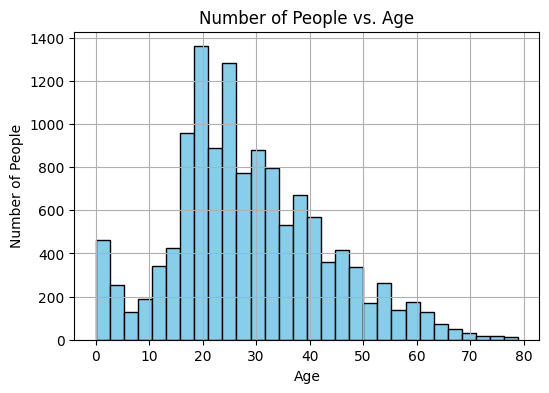

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(concatenated_df["Age"], bins=30, color='skyblue', edgecolor='black')
plt.title('Number of People vs. Age')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.grid(True)
plt.show()

<Axes: xlabel='Age', ylabel='Count'>

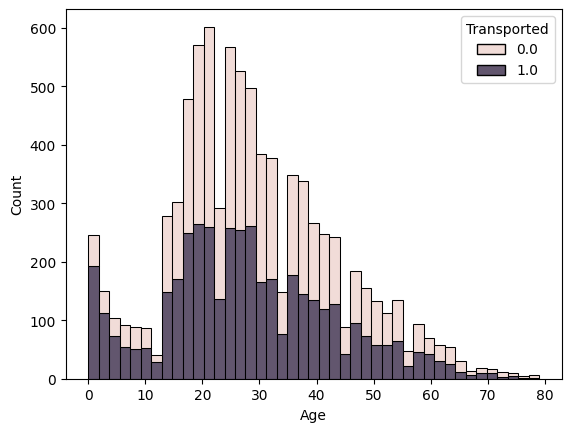

In [ ]:
sns.histplot(data=concatenated_df, x="Age", hue="Transported", multiple="stack")

In [ ]:
train_df_copy = train_df.copy()

In [ ]:
train_df_copy = do_job(train_df_copy, return_df = True)

In [ ]:
bins = [0, 11, 20, 30, 45, 60, float('inf')]
labels = [0, 1, 2, 3, 4, 5]

In [ ]:
train_df_copy['AgeGroup'] = pd.cut(train_df_copy['Age'], bins=bins, labels=labels, right=False,ordered=False)

In [ ]:
train_df_copy.drop('Age', axis=1, inplace=True)

In [ ]:
train_df_copy.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup,Spending,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,AgeGroup
0,False,False,0.0,0.0,0.0,0.0,0.0,False,False,0.0,...,0,0,0,0,0,0,0,0,1,3
1,False,False,109.0,9.0,25.0,549.0,44.0,True,False,736.0,...,0,0,1,0,0,0,0,0,1,2
2,False,True,43.0,3576.0,0.0,6715.0,49.0,False,True,10383.0,...,0,0,0,0,0,0,0,0,1,4
3,False,False,0.0,1283.0,371.0,3329.0,193.0,False,True,5176.0,...,0,0,0,0,0,0,0,0,1,3
4,False,False,303.0,70.0,151.0,565.0,2.0,True,False,1091.0,...,0,0,1,0,0,0,0,0,1,1


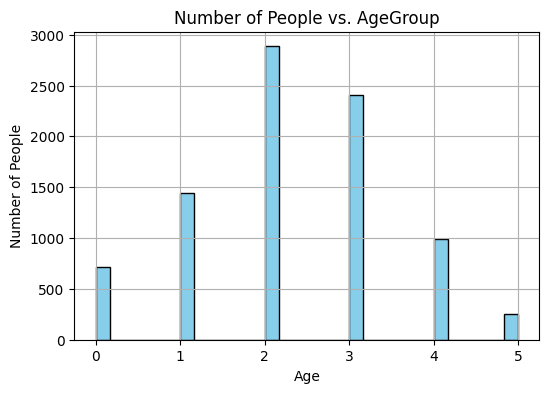

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(train_df_copy["AgeGroup"], bins=30, color='skyblue', edgecolor='black')
plt.title('Number of People vs. AgeGroup')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.grid(True)
plt.show()

In [ ]:
y = train_df_copy.Transported

In [ ]:
X = train_df_copy.drop('Transported', axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [ ]:
group_age_tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=17)

In [ ]:
group_age_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=17)

In [ ]:
group_age_pred = group_age_tree.predict(X_valid)

In [ ]:
print(f"С медианой по палубам, групповой возраст {accuracy_score(y_valid, group_age_pred)}")

С медианой по палубам, групповой возраст 0.786042944785276


С медианой по палубам, age=11, age_func=median 0.7868098159509203

-> Потеряли в точности. Если не нужно для других методов, то стоит отказаться.

# logreg

In [ ]:
X_train_scaled_pca, X_valid_scaled_pca, y_train, y_valid = do_job(train_df.copy(),
           train_test=True, st_pca = True)

In [ ]:
LogisticRegression_reg = LogisticRegression()

In [ ]:
LogisticRegression_reg.fit(X_train_scaled_pca, y_train)

LogisticRegression()

In [ ]:
LogisticRegression_reg.score(X_valid_scaled_pca, y_valid)

0.7940950920245399

### Регуляризация


In [ ]:
from __future__ import division, print_function

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
C = 1e-2
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)

In [ ]:
logit.fit(X_train_scaled_pca, y_train)

LogisticRegression(C=0.01, n_jobs=-1, random_state=17)

In [ ]:
print(logit.score(X_valid_scaled_pca, y_valid))

0.7822085889570553


In [ ]:
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_train_scaled_pca, y_train)
print(logit.score(X_valid_scaled_pca, y_valid))

0.7940950920245399


In [ ]:
C = 10000
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_train_scaled_pca, y_train)
print(logit.score(X_valid_scaled_pca, y_valid))

0.7944785276073619


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [ ]:
logit = LogisticRegression(n_jobs=-1, random_state=17)

In [ ]:
param_grid_logit = {'C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(X_train_scaled_pca, y_train)
grid_logit.best_params_, grid_logit.best_score_
grid_logit.score(X_valid_scaled_pca, y_valid)

0.7940950920245399

In [ ]:
grid_logit.best_params_, grid_logit.best_score_

({'C': 1.0}, 0.7911258157116291)

# Сравнение нескольких моделей

In [ ]:
train_df_copy = train_df.copy()

In [ ]:
X_train_mix, X_valid_mix, y_train_mix, y_valid_mix = do_job(train_df_copy, train_test=True)

In [ ]:
X_train_scaled = ss.fit_transform(X_train_mix)
X_valid_scaled = ss.transform(X_valid_mix)

In [ ]:
pca = PCA(n_components=20)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_valid_scaled_pca = pca.transform(X_valid_scaled)

In [ ]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

In [ ]:
ss = StandardScaler()

In [ ]:
train_df_copy = do_job(train_df_copy, return_df=True)
test_df_copy = do_job(test_df_copy, return_df=True)

In [ ]:
train_df_copy.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,False,...,0,0,0,0,0,0,0,0,0,1
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,False,...,0,0,0,1,0,0,0,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,True,...,0,0,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,True,...,0,0,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,False,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
train_df_copy.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'HaveGroup', 'Spending',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Side_P',
       'Side_S', 'Side_n', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_n', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'],
      dtype='object')

In [ ]:
y_train = train_df_copy['Transported']
X_train = train_df_copy.drop('Transported', axis=1)

In [ ]:
X_concat = pd.concat([X_train, test_df_copy], axis=0, ignore_index=True)

In [ ]:
X_concat_scaled = ss.fit_transform(X_concat)

In [ ]:
train_data_index = len(train_df)
test_data_index = len(X_concat_scaled) - len(test_df)

In [ ]:
X_train_scaled = X_concat_scaled[:train_data_index]
X_test_scaled = X_concat_scaled[test_data_index:]

In [ ]:
pca = PCA(n_components=20)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_valid_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
LogisticRegression_reg = LogisticRegression()
svc_reg = SVC()
KNeighborsClassifier_reg =  KNeighborsClassifier(n_neighbors = 3)
linear_svc = LinearSVC()
decision_tree_reg = DecisionTreeClassifier()
random_forest_reg = RandomForestClassifier(n_estimators=100)

In [ ]:
LogisticRegression_reg.fit(X_train_scaled_pca, y_train)
svc_reg.fit(X_train_scaled_pca, y_train)
KNeighborsClassifier_reg.fit(X_train_scaled_pca, y_train)
linear_svc.fit(X_train_scaled_pca, y_train)
decision_tree_reg.fit(X_train_scaled_pca, y_train)
random_forest_reg.fit(X_train_scaled_pca, y_train)

RandomForestClassifier()

In [ ]:
LogisticRegression_reg_preds = LogisticRegression_reg.predict(X_valid_scaled_pca)
svc_reg_preds = svc_reg.predict(X_valid_scaled_pca)
KNeighborsClassifier_reg_preds = KNeighborsClassifier_reg.predict(X_valid_scaled_pca)
linear_svc_reg_preds = linear_svc.predict(X_valid_scaled_pca)
decision_tree_reg_preds = decision_tree_reg.predict(X_valid_scaled_pca)
random_forest_reg_preds = random_forest_reg.predict(X_valid_scaled_pca)

In [ ]:
predictions_df = pd.DataFrame({
    'Logistic Regression': LogisticRegression_reg_preds,
    'Support Vector Machines': svc_reg_preds,
    'KNN': KNeighborsClassifier_reg_preds,
    'Linear SVC': linear_svc_reg_preds,
    'Decision Tree': decision_tree_reg_preds,
    'Random Forest': random_forest_reg_preds
})

In [ ]:
predictions_df.head()

,Logistic Regression,Support Vector Machines,KNN,Linear SVC,Decision Tree,Random Forest
0,True,True,True,True,True,True
1,False,False,False,False,False,False
2,True,True,True,True,True,True
3,True,True,True,True,True,True
4,True,True,False,True,False,True


In [ ]:
max_values = predictions_df.sum(axis=1)

In [ ]:
answers = max_values.apply(lambda x: 1 if x >=4  else 0)

In [ ]:
test_ids = test_df['PassengerId']

submission_df = pd.DataFrame({'PassengerId': test_ids, 'Survived': answers})

# Save the submission DataFrame to a CSV file
#submission_df.to_csv('submit.csv', index=False)

# Print the head of the submission DataFrame
print(submission_df.head())

  PassengerId  Survived
0     0013_01         1
1     0018_01         0
2     0019_01         1
3     0021_01         1
4     0023_01         1


In [ ]:
count_ones = submission_df['Survived'].sum()
count_zeros = len(submission_df) - count_ones

print("Number of 1s:", count_ones)
print("Number of 0s:", count_zeros)

Number of 1s: 1956
Number of 0s: 2321


# Ансамбли

## Стекинг

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

In [ ]:
estimators = [('lr', LogisticRegression(C=1)),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3))]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.7883435582822086


In [ ]:
estimators = [('lr', LogisticRegression(C=1)),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3))]
modelClf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.7914110429447853


In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3)),]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.7883435582822086


In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3)),
              ('lsvc', LinearSVC())]
modelClf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.7887269938650306


In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3)),
              ('lsvc', LinearSVC())]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.7894938650306749


In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=9)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3)),
              ('lsvc', LinearSVC())]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.7894938650306749


In [ ]:
X_train_scaled_pca, X_valid_scaled_pca, y_train, y_valid = do_job(train_df.copy(),
           train_test=True, return_df = False, improved_age = True, st_pca = True, not_alone=False)

In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3)),
              ('lsvc', LinearSVC())]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.7979294478527608


In [ ]:
X_train_scaled_pca, y_train = do_job(train_df.copy(), return_df =False, target='Transported', group_apply=['Destination', 'Cabin', 'HomePlanet'], delete=['PassengerId', 'PassengerGroup'],
           dummies=['HomePlanet', 'Side', 'Deck', 'Destination'], id_column='PassengerId',
           train_test=False, improved_age = True, st_pca = False, not_alone=False,
           improved_age_func='median', age = 11)

In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3)),
              ('lsvc', LinearSVC())]
modelClf_final = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

modelClf_final.fit(X_train_scaled_pca, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('dt',
                                DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=7)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=15,
                                                       min_samples_leaf=18,
                                                       min_samples_split=23,
                                                       n_estimators=700)),
                               ('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('lsvc', LinearSVC())],
                   final_estimator=LogisticRegression())

In [ ]:
X_test = do_job(test_df, return_df = True, target='Transported', group_apply=['Destination', 'Cabin', 'HomePlanet'], delete=['PassengerId', 'PassengerGroup'],
           dummies=['HomePlanet', 'Side', 'Deck', 'Destination'], id_column='PassengerId',
           train_test=False, improved_age = True, st_pca = False, not_alone=False,
           improved_age_func='median', age = 11)

In [ ]:
X_test_scaled = ss.transform(X_test)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
modelClf_final.predict(X_test_scaled_pca)

ValueError: ignored

In [ ]:
stacking_predictions = modelClf_final.predict(X_test_scaled_pca)

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

modelClf_Ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8), n_estimators=700, random_state=12)

modelClf_Ada.fit(X_train_scaled_pca, y_train_mix)
print(modelClf_Ada.score(X_valid_scaled_pca, y_valid_mix))

0.7515337423312883


## Бэггинг

In [ ]:
from sklearn.ensemble import BaggingClassifier

modelClf_bagging = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=50, random_state=12)

modelClf_bagging.fit(X_train_scaled_pca, y_train_mix)
print(modelClf_bagging.score(X_valid_scaled_pca, y_valid_mix))

0.7986963190184049


# Kaggle с ансамблем

In [ ]:
concatenated_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [ ]:
y_train_kaggle = train_df.Transported

In [ ]:
concatenated_df_X = concatenated_df.drop('Transported', axis = 1)

In [ ]:
concatenated_jobs_df = do_job(concatenated_df_X.copy(), return_df = True, st_pca=False)

In [ ]:
concatenated_jobs_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HaveGroup,Spending,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0,0,0,0,0,0,0,0,0,1
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,False,736.0,...,0,0,0,1,0,0,0,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,True,10383.0,...,0,0,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,True,5176.0,...,0,0,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,False,1091.0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
concatenated_jobs_df.isnull().sum()

CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HaveGroup                    0
Spending                     0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Side_P                       0
Side_S                       0
Side_n                       0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_T                       0
Deck_n                       0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
dtype: int64

In [ ]:
train_data_index = len(train_df)
test_data_index = len(concatenated_jobs_df) - len(test_df)

In [ ]:
kaggle_X_train_scaled = concatenated_jobs_df[:train_data_index]
kaggle_X_test_scaled = concatenated_jobs_df[test_data_index:]

In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700, n_jobs=-1)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3))]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(kaggle_X_train_scaled, y_train_kaggle)

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('dt',
                                DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=7)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=15,
                                                       min_samples_leaf=18,
                                                       min_samples_split=23,
                                                       n_estimators=700,
                                                       n_jobs=-1)),
                               ('knn', KNeighborsClassifier(n_neighbors=3))],
                   final_estimator=SVC())

In [ ]:
answers = modelClf.predict(kaggle_X_test_scaled)

In [ ]:
test_ids = test_df['PassengerId']

submission_df = pd.DataFrame({'PassengerId': test_ids, 'Transported': answers})

In [ ]:
submission_df.set_index('PassengerId').to_csv('Stacking_kaggle.csv')

## Повторно проверим точность с "один в каюте" и без

In [ ]:
X_train_scaled_pca, X_valid_scaled_pca, y_train, y_valid = do_job(train_df.copy(),
           train_test=True, return_df = False, improved_age = True, st_pca = True, not_alone=True)

In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700, n_jobs=-1)),
              ('knn',  KNeighborsClassifier(n_neighbors = 3))]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.8002300613496932


In [ ]:
X_train_scaled_pca_2, X_valid_scaled_pca_2, y_train_2, y_valid_2 = do_job(train_df.copy(),
           train_test=True, return_df = False, improved_age = True, st_pca = True, not_alone=False)

# Предобработка через категории, без стандартизации. (76%, плохая идея)

In [ ]:
concatenated_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [ ]:
concat_df = do_job(concatenated_df.copy(),
           train_test=False, return_df = True, improved_age = True, st_pca = False, not_alone=True,
           improved_age_func='median', age = 11)

In [ ]:
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck']

for column in spending_columns:
  concat_df.loc[concat_df[column] == 0, column] = 0
  concat_df.loc[concat_df[column] > 0, column] = 1
  concat_df[column] = concat_df[column].astype(int)

In [ ]:
concat_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,False,39.0,False,0,0,0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,1
1,False,24.0,False,1,1,1,1,1,True,False,...,0,0,0,1,0,0,0,0,0,1
2,False,58.0,True,1,1,0,1,1,False,True,...,0,0,0,0,0,0,0,0,0,1
3,False,33.0,False,0,1,1,1,1,False,True,...,0,0,0,0,0,0,0,0,0,1
4,False,16.0,False,1,1,1,1,1,True,False,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
concatenated_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Воспользуемся кластеризацией для проставления групп по тратам

In [ ]:
fare_data = np.array(concat_df["Spending"])

In [ ]:
fare_data_reshaped = fare_data.reshape(-1, 1)

In [ ]:
fare_data

array([    0.,   736., 10383., ...,     0.,  3203.,     0.])

In [ ]:
optimal_clusters = 5

In [ ]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(fare_data.reshape(-1, 1))
    wcss.append(kmeans.inertia_)

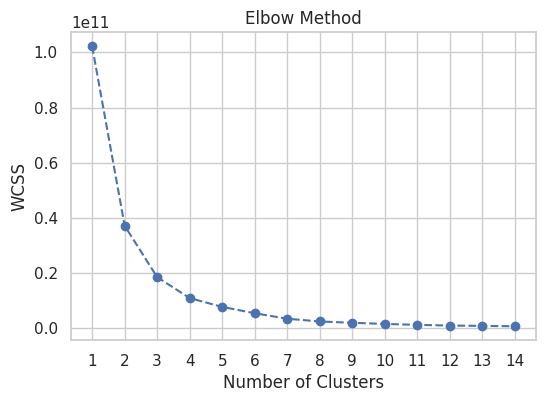

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.xticks(np.arange(1, 15, 1))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(fare_data_reshaped)

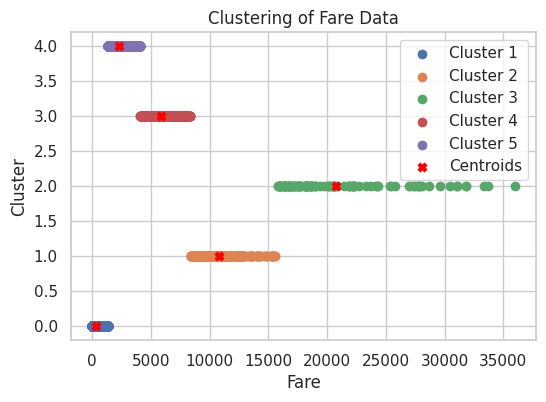

In [ ]:
plt.figure(figsize=(6, 4))
for i in range(optimal_clusters):
    plt.scatter(fare_data_reshaped[cluster_labels == i], [i] * len(fare_data_reshaped[cluster_labels == i]), label=f'Cluster {i+1}')

plt.scatter(kmeans.cluster_centers_, np.arange(optimal_clusters), color='red', marker='X', label='Centroids')
plt.xlabel('Fare')
plt.ylabel('Cluster')
plt.title('Clustering of Fare Data')
plt.legend()
plt.show()


In [ ]:
# Финально.
optimal_clusters = 5
fare_data = np.array(concat_df["Spending"])
# Reshape the fare data to be a 2D array
fare_data_reshaped = fare_data.reshape(-1, 1)
# Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(fare_data_reshaped)

# Add the cluster labels as a new column to the DataFrame
concat_df["Cluster"] = cluster_labels

In [ ]:
concat_df.drop('Spending', axis=1, inplace=True)

In [ ]:
concat_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cluster
0,False,39.0,False,0,0,0,0,0,False,False,...,0,0,0,0,0,0,0,0,1,0
1,False,24.0,False,1,1,1,1,1,True,False,...,0,0,1,0,0,0,0,0,1,0
2,False,58.0,True,1,1,0,1,1,False,True,...,0,0,0,0,0,0,0,0,1,1
3,False,33.0,False,0,1,1,1,1,False,True,...,0,0,0,0,0,0,0,0,1,3
4,False,16.0,False,1,1,1,1,1,True,False,...,0,0,1,0,0,0,0,0,1,0


## Попробую через PCA выбрать категории для возраста

In [ ]:
concat_df_age = concat_df[['Age', 'Transported']]

In [ ]:
concat_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cluster
0,False,39.0,False,0,0,0,0,0,False,False,...,0,0,0,0,0,0,0,0,1,0
1,False,24.0,False,1,1,1,1,1,True,False,...,0,0,1,0,0,0,0,0,1,0
2,False,58.0,True,1,1,0,1,1,False,True,...,0,0,0,0,0,0,0,0,1,1
3,False,33.0,False,0,1,1,1,1,False,True,...,0,0,0,0,0,0,0,0,1,3
4,False,16.0,False,1,1,1,1,1,True,False,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
concat_df_age.head()

,Age,Transported
0,39,False
1,24,True
2,58,False
3,33,False
4,16,True


In [ ]:
concat_df_age["Age"] = concat_df_age["Age"].astype('int')

<ipython-input-77-98c90fbae306>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_df_age["Age"] = concat_df_age["Age"].astype('int')


In [ ]:
concat_dummies_age = pd.concat([concat_df_age, pd.get_dummies(concat_df_age["Age"], prefix="Age")], axis=1)

In [ ]:
concat_dummies_age.drop('Age', axis=1, inplace=True)

In [ ]:
train_data_index = len(train_df)

In [ ]:
X_train_age = concat_dummies_age[:train_data_index]
X_test_age = concat_dummies_age[train_data_index:]
y_train_age = X_train_age.Transported
X_train_age.drop('Transported', axis=1, inplace=True)

<ipython-input-94-a27400a1cb7f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_age.drop('Transported', axis=1, inplace=True)


In [ ]:
X_train_age.head()

,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,...,Age_70,Age_71,Age_72,Age_73,Age_74,Age_75,Age_76,Age_77,Age_78,Age_79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
concat_dummies_age.head()

,Transported,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,...,Age_70,Age_71,Age_72,Age_73,Age_74,Age_75,Age_76,Age_77,Age_78,Age_79
0,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Значения возраста, к-ый больше влияет на предсказание

In [ ]:
# dense to sparse
from numpy import array
from scipy.sparse import csr_matrix

In [ ]:
from sklearn.decomposition import SparsePCA
from sklearn.datasets import load_digits

In [ ]:
matrix = csr_matrix(X_train_age)

In [ ]:
forest_age = RandomForestClassifier()

In [ ]:
X_train_age = X_train_age.astype(int)

In [ ]:
y_train_age.dtypes

Age_0     int64
Age_1     int64
Age_2     int64
Age_3     int64
Age_4     int64
          ...  
Age_75    int64
Age_76    int64
Age_77    int64
Age_78    int64
Age_79    int64
Length: 80, dtype: object

In [ ]:
y_train_age = y_train_age.astype(bool)

In [ ]:
forest_age.fit(X_train_age, y_train_age)

RandomForestClassifier()

In [ ]:
feats = {}
for feature, importance in zip(X_train_age.columns, forest_age.feature_importances_):
  feats[feature] = importance

In [ ]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})

In [ ]:
importances = importances.sort_values(by='Gini-Importance', ascending=False).reset_index()\
    .rename(columns={'index': 'Features'})

Text(0.5, 1.0, 'Feature Importance')

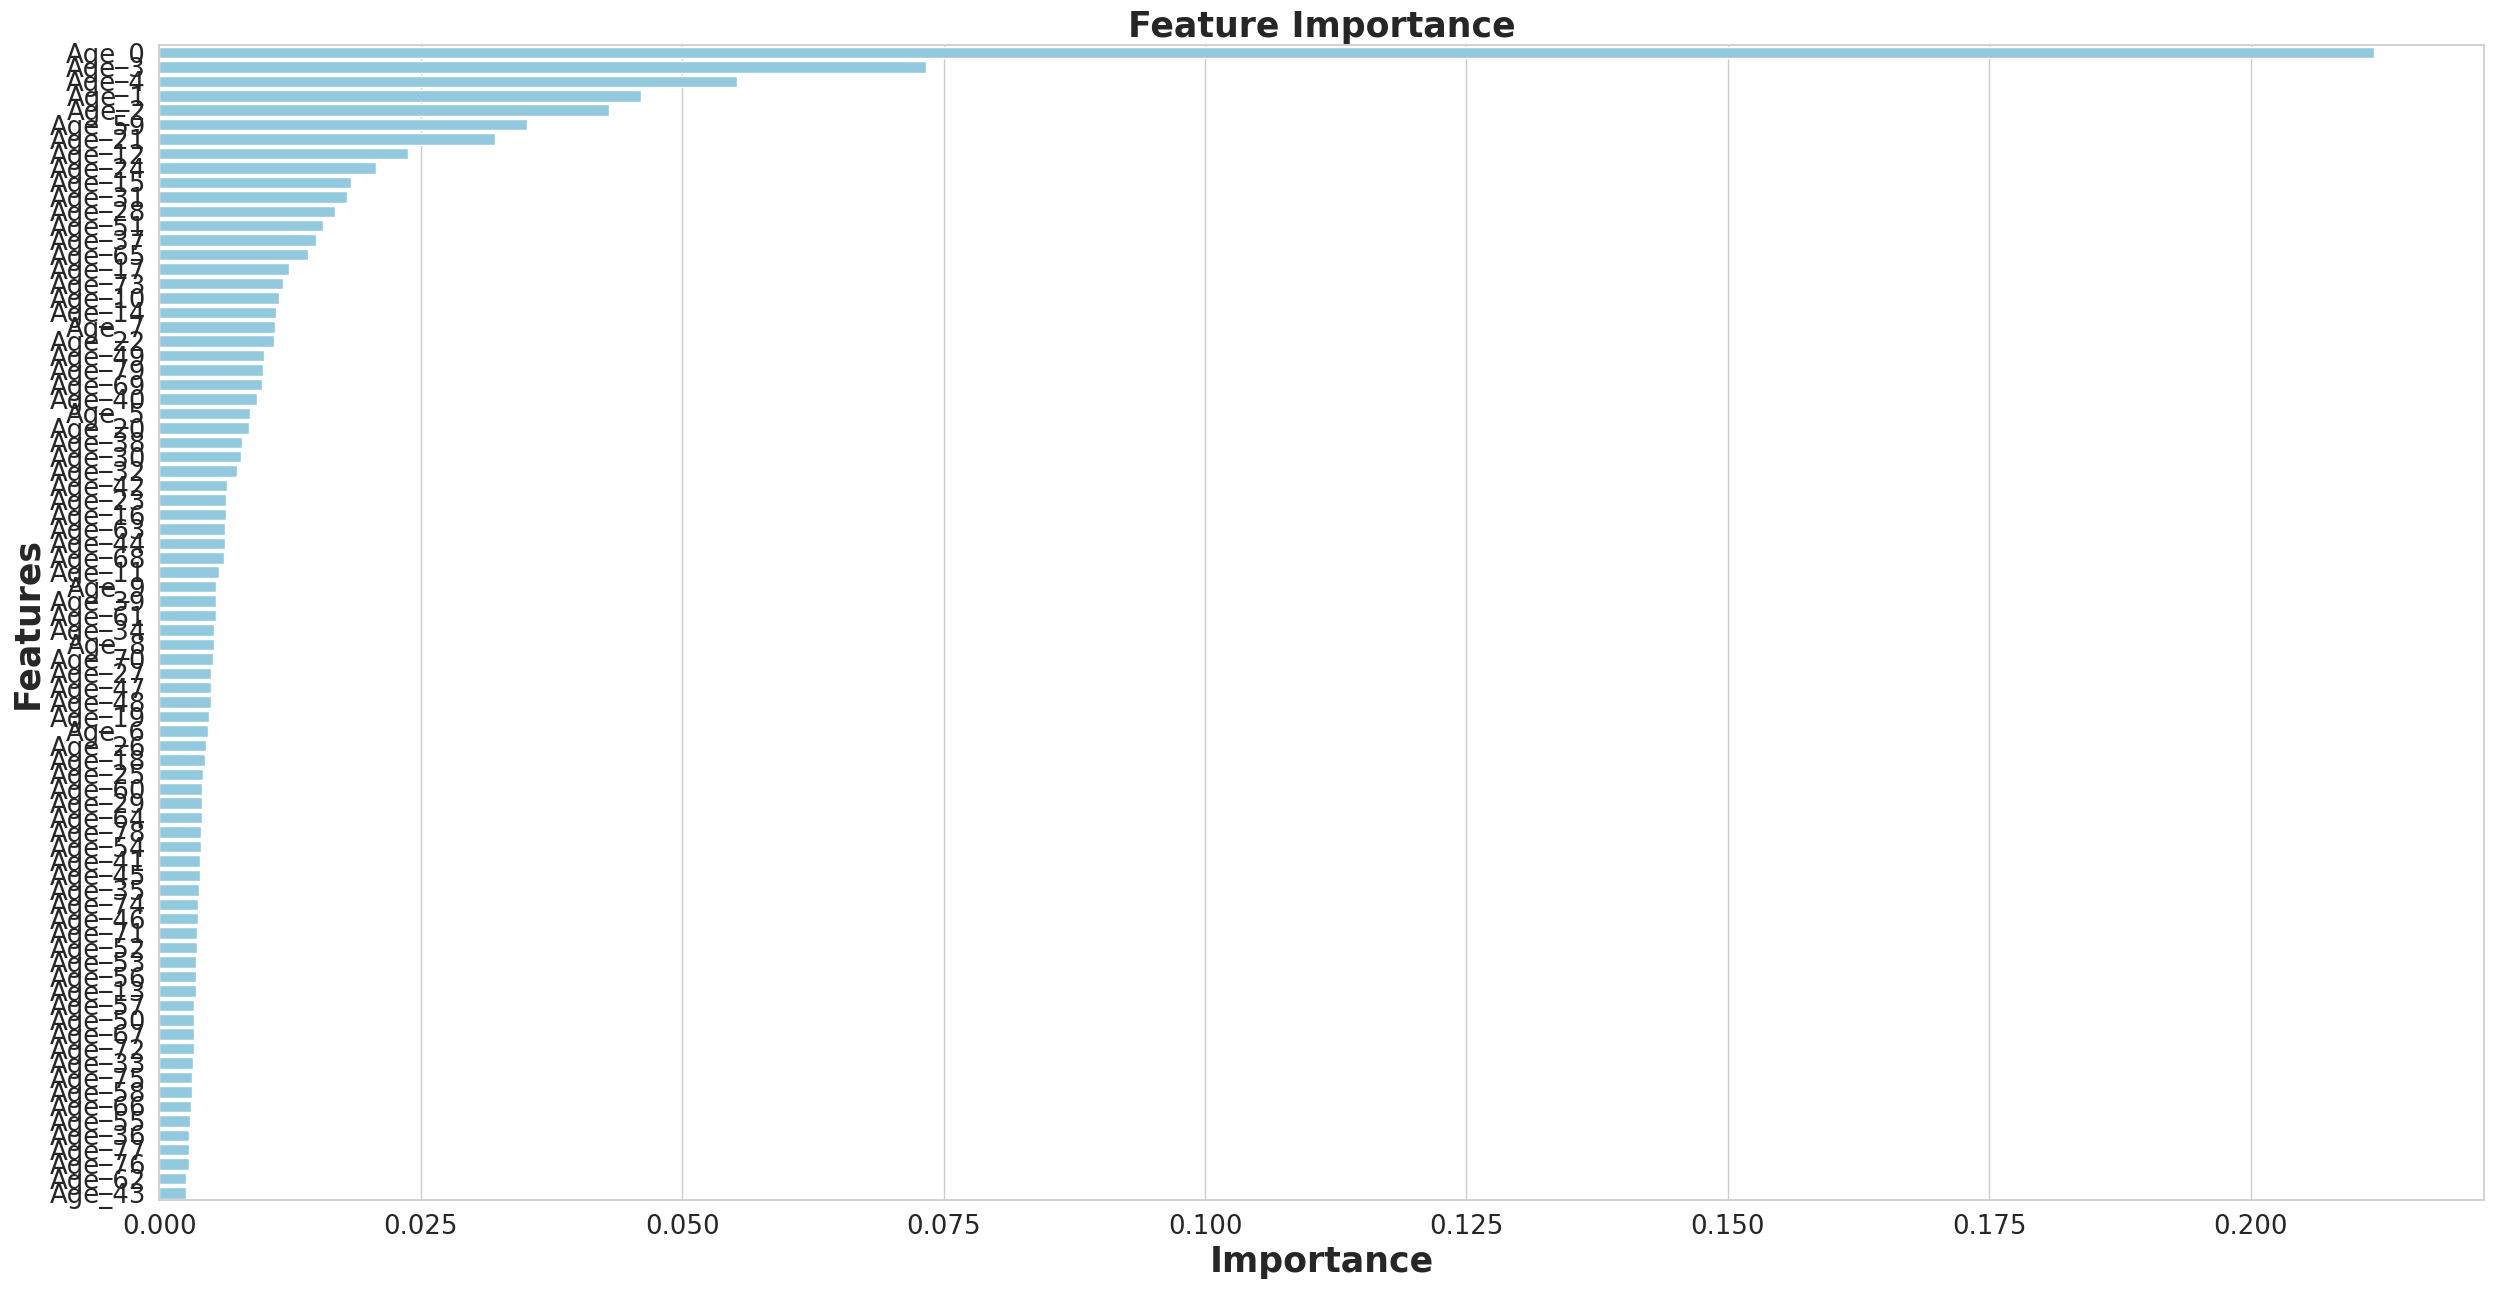

In [ ]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue');
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')

In [ ]:
importances.shape

(80, 2)

In [ ]:
pca_test = PCA(n_components=80)

In [ ]:
pca_test.fit(X_train_age)

PCA(n_components=80)

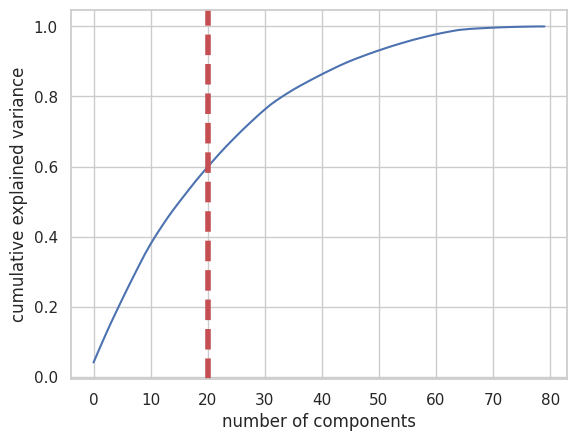

None

In [ ]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=20, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr

In [ ]:
pca_df

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.040417,4.041679e-02
1,0.078364,3.794771e-02
2,0.115611,3.724602e-02
3,0.151700,3.608936e-02
4,0.186120,3.442003e-02
...,...,...
75,0.999171,3.609989e-04
76,0.999524,3.529677e-04
77,0.999765,2.405760e-04
78,1.000000,2.353118e-04


## Категории, предсказание

In [ ]:
concat_df[['CryoSleep', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'HaveGroup', 'NotAlone',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Side_P',
       'Side_S', 'Side_n', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_n', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']] = concat_df[['CryoSleep', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'HaveGroup', 'NotAlone',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Side_P',
       'Side_S', 'Side_n', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_n', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']].astype(bool)

In [ ]:
concat_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HaveGroup,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cluster
0,False,39.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0
1,False,24.0,False,True,True,True,True,True,True,False,...,False,False,True,False,False,False,False,False,True,0
2,False,58.0,True,True,True,False,True,True,False,True,...,False,False,False,False,False,False,False,False,True,1
3,False,33.0,False,False,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,True,3
4,False,16.0,False,True,True,True,True,True,True,False,...,False,False,True,False,False,False,False,False,True,0


In [ ]:
index = len(train_df)
X_train = concat_df[:index]
X_test = concat_df[index:]
X_test.drop('Transported', axis=1, inplace=True)
y_train = X_train['Transported']
X_train.drop('Transported', axis=1, inplace=True)

<ipython-input-154-75a59c20b469>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('Transported', axis=1, inplace=True)
<ipython-input-154-75a59c20b469>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('Transported', axis=1, inplace=True)


In [ ]:
X_train_bool, X_valid_bool, y_train_bool, y_valid_bool = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

In [ ]:
forest_bool = RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)

In [ ]:
forest_bool.fit(X_train_bool, y_train_bool)
forest_bool.score(X_valid_bool, y_valid_bool)

0.7664877300613497

In [ ]:
logreg_bool = LogisticRegression()

In [ ]:
logreg_bool.fit(X_train_bool, y_train_bool)
logreg_bool.score(X_valid_bool, y_valid_bool)

0.7442484662576687

In [ ]:
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier()),
              ('rf', RandomForestClassifier()),
              ('knn',  KNeighborsClassifier(n_neighbors = 3))]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(X_train_bool, y_train_bool)
print(modelClf.score(X_valid_bool, y_valid_bool))

0.7427147239263804


# GBC

In [ ]:
X_train_scaled_pca, X_valid_scaled_pca, y_train, y_valid = do_job(train_df.copy(),
           train_test=True, return_df = False, improved_age = True, st_pca = False, not_alone=False, pca=False)

In [ ]:
gbc = GradientBoostingClassifier(learning_rate= 0.2, n_estimators = 100)

In [ ]:
gbc.fit(X_train_scaled_pca, y_train)
predi = gbc.predict(X_valid_scaled_pca)

gbc.score(X_valid_scaled_pca, y_valid)

0.8113496932515337

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, auc, precision_score, f1_score, confusion_matrix

In [ ]:
rfc = RandomForestClassifier()
dtr = DecisionTreeClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()
ada = AdaBoostClassifier(),
gb = GradientBoostingClassifier()
xg = xgb.XGBClassifier()

In [ ]:
dic = {'KNeighborsClassifier': knn, 'LogisticRegression': lr,
       'DecisionTreeClassifier':dtr, 'RandomForestClassifier':rfc
       , 'GradientBoostingClassifier': gb
          ,'XGBoost': xg}

In [ ]:
X_train_scaled_pca[['VIP', 'CryoSleep']] = X_train_scaled_pca[['VIP', 'CryoSleep']].astype(bool)
X_valid_scaled_pca[['VIP', 'CryoSleep']] = X_valid_scaled_pca[['VIP', 'CryoSleep']].astype(bool)

In [ ]:
for key in dic:
    print(key)
    dic[key].fit(X_train_scaled_pca, y_train)
    print('training ' ,dic[key].score(X_train_scaled_pca, y_train))
    print('testing ' , dic[key].score(X_valid_scaled_pca, y_valid))
    print(" ")

KNeighborsClassifier
training  0.8312243221035333
testing  0.781441717791411
 
LogisticRegression
training  0.7863599013968776
testing  0.7975460122699386
 
DecisionTreeClassifier
training  0.9587510271158587
testing  0.7358128834355828
 
RandomForestClassifier
training  0.9587510271158587
testing  0.7925613496932515
 
GradientBoostingClassifier
training  0.819227608874281
testing  0.8109662576687117
 
XGBoost
training  0.9207888249794577
testing  0.7948619631901841
 


In [ ]:
parameters = {
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7,9]},
    'LogisticRegression': {'C': [0.1, 1, 10]},
    'DecisionTreeClassifier': {'max_depth': [5, 10, 20, 30]},
    'RandomForestClassifier': {'n_estimators': [50, 100, 200]},
    'GradientBoostingClassifier': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.2, 0.3]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

In [ ]:
def best_hyp(models, parameters, xtrain, ytrain, xtest, ytest):
    best_models = {}

    for model_name, model in models.items():
        print(model_name)
        grid_search = GridSearchCV(model, parameters[model_name], cv=5, n_jobs=-1, scoring='accuracy')
        grid_search.fit(xtrain, ytrain)

        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model

        print('Best Hyperparameters:', grid_search.best_params_)
        print('Training Accuracy:', best_model.score(xtrain, ytrain))
        print('Testing Accuracy:', best_model.score(xtest, ytest))
        print()

    return best_models

In [ ]:
best_hyperparameters = best_hyp(dic, parameters, X_train_scaled_pca, y_train, X_valid_scaled_pca, y_valid)

KNeighborsClassifier
Best Hyperparameters: {'n_neighbors': 9}
Training Accuracy: 0.8162695152013147
Testing Accuracy: 0.786042944785276

LogisticRegression
Best Hyperparameters: {'C': 0.1}
Training Accuracy: 0.7881676253081348
Testing Accuracy: 0.7983128834355828

DecisionTreeClassifier
Best Hyperparameters: {'max_depth': 5}
Training Accuracy: 0.7921117502054231
Testing Accuracy: 0.7852760736196319

RandomForestClassifier
Best Hyperparameters: {'n_estimators': 200}
Training Accuracy: 0.9587510271158587
Testing Accuracy: 0.7875766871165644

GradientBoostingClassifier
Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 200}
Training Accuracy: 0.8331963845521775
Testing Accuracy: 0.8101993865030674

XGBoost
Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 50}
Training Accuracy: 0.8397699260476582
Testing Accuracy: 0.8101993865030674



In [ ]:
estimators = [('lr', LogisticRegression(C=0.1)),
              ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=True, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 9)),
              ('gbc', GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
              ('xgb', xgb.XGBClassifier(learning_rate= 0.1, n_estimators= 50))]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(X_train_scaled_pca, y_train)
print(modelClf.score(X_valid_scaled_pca, y_valid))

0.8125


#...

In [ ]:
concatenated_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [ ]:
y_train_kaggle = train_df.Transported

In [ ]:
concatenated_df_X = concatenated_df.drop('Transported', axis = 1)

In [ ]:
concatenated_jobs_df = do_job(concatenated_df_X.copy(), return_df = True, st_pca=False)

In [ ]:
concatenated_jobs_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HaveGroup,Spending,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0,0,0,0,0,0,0,0,0,1
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,False,736.0,...,0,0,0,1,0,0,0,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,True,10383.0,...,0,0,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,True,5176.0,...,0,0,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,False,1091.0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
concatenated_jobs_df.isnull().sum()

CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HaveGroup                    0
Spending                     0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Side_P                       0
Side_S                       0
Side_n                       0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_T                       0
Deck_n                       0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
dtype: int64

In [ ]:
train_data_index = len(train_df)
test_data_index = len(concatenated_jobs_df) - len(test_df)

In [ ]:
kaggle_X_train_scaled = concatenated_jobs_df[:train_data_index]
kaggle_X_test_scaled = concatenated_jobs_df[test_data_index:]

In [ ]:
kaggle_X_train_scaled[['CryoSleep', 'VIP']] = kaggle_X_train_scaled[['CryoSleep', 'VIP']].astype(bool)
kaggle_X_test_scaled[['CryoSleep', 'VIP']] = kaggle_X_test_scaled[['CryoSleep', 'VIP']].astype(bool)

<ipython-input-247-35bb5edcd872>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_X_train_scaled[['CryoSleep', 'VIP']] = kaggle_X_train_scaled[['CryoSleep', 'VIP']].astype(bool)
<ipython-input-247-35bb5edcd872>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_X_test_scaled[['CryoSleep', 'VIP']] = kaggle_X_test_scaled[['CryoSleep', 'VIP']].astype(bool)


In [ ]:
estimators = [('lr', LogisticRegression(C=0.1)),
              ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=7)),
              ('rf', RandomForestClassifier(bootstrap=True, max_depth=15, max_features='sqrt', min_samples_leaf=18, min_samples_split=23, n_estimators=700)),
              ('knn',  KNeighborsClassifier(n_neighbors = 9)),
              ('gbc', GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
              ('xgb', xgb.XGBClassifier(learning_rate= 0.1, n_estimators= 50))]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

modelClf.fit(kaggle_X_train_scaled, y_train_kaggle)

StackingClassifier(estimators=[('lr', LogisticRegression(C=0.1)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_leaf=7)),
                               ('rf',
                                RandomForestClassifier(max_depth=15,
                                                       min_samples_leaf=18,
                                                       min_samples_split=23,
                                                       n_estimators=700)),
                               ('knn', KNeighborsClassifier(n_neighbors=9)),
                               ('gbc',
                                GradientBoostingClassifier(n_estimators=200)),
                               ('xgb',
                                XGBClassifier(base...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=50, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=SVC())

In [ ]:
answers = modelClf.predict(kaggle_X_test_scaled)

In [ ]:
test_ids = test_df['PassengerId']

submission_df = pd.DataFrame({'PassengerId': test_ids, 'Transported': answers})

In [ ]:
submission_df.set_index('PassengerId').to_csv('Stacking_kaggle_2.csv')